# Introduction

---

This notebook uses the review text to classify movie reviews into positive or negative categories. It's a **two-class classification**, or binary classification, which is an important and common kind of machine learning problem.



The main goal of this task is to find a reliable way to evaluate the performance of the model so that the relationship between **optimization and generalization, underfitting and overfitting** could be monitored and observed, i.e, to find a balance in the tension.


Note: the results of Min.V.Loss and Max.V.Acc in the **Performance on Validation Set comparison chart:** can not be rendered in exported html format, for more details, please check the notebook.


# Methodology
---


### Overview

#### Feasibility

The IMDB dataset is from the nternet Movie Database (IMDB), which contains 50,000 movie review texts, half for training and half for testing. They contain an **equal number of positive and negative reviews**. It also has both reviews and labels which meet the conditions of training. This notebook uses tf.keras, which is a high-level API for building and training models in Tensorflow. The imdb datasets comes packaged with Keras, and it has already been turned into **sequences of integers**. This enables us to focus on model building, training, and evaluation. 

The problem is to classify positive and negative movie reviews, therefore it's two-class classification - each input sample should be classified into two mutually opposing categories.

#### Workflow

Input preparation: 
- Load dataset and understand the date structure
- Vectorize the data: convert lists into tensors

Model building:
- Build a basic model that has statistical power

Validating the approach:
- Use a validation set to monitor the accuracy of the model during training. 

Developing a model that overfits:
- Scale up the model

Hyperparameter tunning:
- Learning rate, momentum, batch size
- Regularization: dropout layers, l1/l2/l1_l2 regularization method
- Grid search/random search

Retrain:
- Retrain with entire training set and evaluate on the unseen test set 

Conclusion:
- Summarize the training observation

## Preparation

### Import nessesary modules

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
### For reproducible results

from numpy.random import seed
seed(1)

tf.random.set_seed(2)


### Define plot function

In [3]:
def plot_loss_acc(model_history):
    
    loss_values = model_history["loss"]
    val_loss_values = model_history["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.subplot(2, 2, 1)
    plt.plot(epochs, loss_values, "--r", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss") 
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    #plt.clf()
    acc = model_history["accuracy"]
    val_acc = model_history["val_accuracy"]
    plt.subplot(2, 2, 2)
    plt.plot(epochs, acc, "--r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    plt.show()

### Load the IMDB dataset 
* Training set - data that the module will learn from

* Test set - the module will be tested on

* 10k vocabulary & frequent usage limitation

In [4]:
from tensorflow.keras.datasets import imdb
((train_data, train_labels), (test_data, test_labels)) = imdb.load_data(num_words=10000) 
# print(max([max(sequence) for sequence in train_data]))

### Have a look at the training data

The dataset is preprocessed: each sample is an array of integers representing the words in the movie review. Each label is an integer value of 0 or 1, where 0 represents a negative review and 1 represents a positive review.
* The review text is converted to integer values
* Where each integer represents a word in the dictionary. 

(Hide output of training_data and call it while needed.) 

In [5]:
%%capture training_data 
print(train_labels)
print(train_data[0])

In [6]:
# training_data() 

In [7]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


### Convert integers back to words

Create a function to query a dictionary object that contains an integer-to-string mapping.

* `word_index` is a dictionary that maps words to integer indexes
* Reverse key and value to map integer indexes to words
* Decodes the comment. The index is subtracted from 3 since 0, 1, 2 are reserved for "padding", "start of sequence", and "unknown".


In [8]:
%%capture decoded_review

word_index = imdb.get_word_index() 

reverse_word_index = dict(
 [(value, key) for (key, value) in word_index.items()])

decoded_review = " ".join(
 [reverse_word_index.get(i - 3, "?") for i in train_data[0]]) 

print(decoded_review)

In [9]:
# decoded_review()

### Turn lists into tensors.

Reviews - i.e., integer lists/arrays must be converted to a tensor before being fed into the neural network. Let's do **multi-hot**! 

So the input of the model will be vectorized text and the lables are scalars

* Turn the lists into vectors of 0s and 1s
* Equal the lengths of different lists
* Vectorize the training&test data
* Convert the lables to float32

In [10]:
def vectorize_sequences(sequences, dimension=10000): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. 
    return results

x_train = vectorize_sequences(train_data) 
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

print(x_train[0])
print(x_test[0])
print(y_train[0])
print(y_test[0])

[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
1.0
0.0


## Building the model (M0)

### Define and compile 

Neural networks are built from stacks of layers, which require architectural decisions in two main sides: how many layers and how many hidden units in each layer.

Basic model:
* intermediate layers with (**input_dimension, 16**) shaped weight matrix 
* output a a single probability - **number between 0 and 1** - how likely the review is to be positive)
* a plain stack of densely connected layers with **relu** activations to implements the tensor operations: $$output = relu(dot(input, W) + b)$$
* compile: configuring the learning process: passed the `optimizer`, `loss`, and `metrics` as strings (such as **`rmsprop`**)
* use **binary crossentropy** for a two-class classification problem
* The final layer is a single dense sigmoid unit;


In [11]:
def imdb_model(layer_1_units, layer_2_units, layer_3_units, lr, momentum, dp, use_regularizer, reg_type, reg_val):
   


    if not use_regularizer :
        model = keras.Sequential([
        layers.Dense(layer_1_units, activation="relu", input_shape=(10000,)),
        layers.Dropout(dp),
        layers.Dense(layer_2_units, activation="relu"),
        layers.Dropout(dp),
        layers.Dense(layer_3_units, activation="sigmoid") 
])

    else:
        model = keras.Sequential([
        layers.Dense(layer_1_units, kernel_regularizer = reg_type(reg_val), activation="relu", input_shape=(10000,)),
        layers.Dropout(dp),
        layers.Dense(layer_2_units, kernel_regularizer=reg_type(reg_val), activation="relu"),
        layers.Dropout(dp),
        layers.Dense(layer_3_units, activation="sigmoid") 
])
    model.compile(optimizer=keras.optimizers.RMSprop(lr, momentum),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
    return model


model = imdb_model(4,4,1,0.001,0.,0., 0 , None, None)
model.summary()


Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 40004     
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


2022-11-13 22:26:11.174999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 22:26:11.175112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Dumb Baseline
Test untrained model's accuracy.
In this case, ith a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%.

In [12]:
results = model.evaluate(x_test, y_test, verbose=0) # test untrained model.

print(f"loss: {results[0]}, accuracy: {results[1]}")

2022-11-13 22:26:11.623136: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 22:26:11.718668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


loss: 0.6931391358375549, accuracy: 0.4962000250816345


## Validating the approach

### Train the model on a validation set

Train the model for 20 epochs in 512-samples sized mini-batches. And monitor loss and
accuracy to track the performance on the 40% samples validation set by setting the validation_split = 0.4.


In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
def train(epochs, batch_size, validation_split):
    
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        callbacks=[tensorboard_callback])
    return history

In [15]:
# reset the model
model = imdb_model(4,4,1,0.001,0.,0., 0 , None, None)

### Track by history
* history is a dictionary containing data about everything that happened during training
* including loss and accuracy during the training process and the validation process

In [16]:
# Model0 training:
M0_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:26:14.891249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 23ms/step - loss: 0.6483 - accuracy: 0.5867 - val_loss: 0.6018 - val_accuracy: 0.7081
Epoch 2/20


2022-11-13 22:26:15.575132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 0.5674 - accuracy: 0.7479 - val_loss: 0.5462 - val_accuracy: 0.7710
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.5127 - accuracy: 0.8245 - val_loss: 0.5069 - val_accuracy: 0.8341
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4707 - accuracy: 0.8647 - val_loss: 0.4778 - val_accuracy: 0.8603
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4366 - accuracy: 0.8887 - val_loss: 0.4570 - val_accuracy: 0.8605
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4078 - accuracy: 0.9052 - val_loss: 0.4418 - val_accuracy: 0.8643
Epoch 7/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3832 - accuracy: 0.9123 - val_loss: 0.4327 - val_accuracy: 0.8635
Epoch 8/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3608 - accuracy: 0.9197 - val_loss: 0.4276 - val_accuracy: 0.8609
Epoch 9/20
30/30 [======

comment: the basic model beats the dumb baseline

### Plot and compare

Plot the Training and validation loss vs Training and validation accuracy comparison

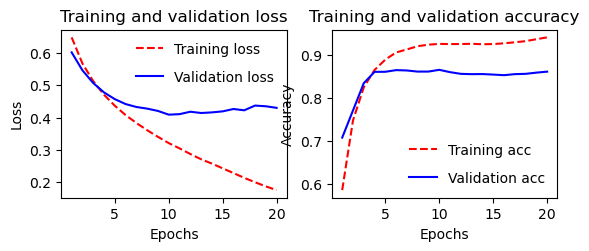

In [17]:
plot_loss_acc(M0_history)

### Observation and comments

- The basic model M0 has beaten the dumb baseline, so it has statistical power.
- In M0, neither the validation loss nor the accuracy has deteriorated significantly to show that it's an obvious overfitting model, so the complexity of the model should be increased, for example, by increasing the number of cells in hidden layers.
- Next step: develop an overfitting model.

## Developing a model that overfits (M1)

An overfit model must be developed to achieve the perfect fit. In order to find the sweet spot, it's nessesary to cross the boundary so it could be found in a bigger sight.

### Try bigger model

In [18]:
model = imdb_model(16,16,1,0.001,0.,0., 0 , None, None)
M1_history = train(20,512,0.4).history


Epoch 1/20
 1/30 [>.............................] - ETA: 17s - loss: 0.6949 - accuracy: 0.4961

2022-11-13 22:26:23.810374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 24ms/step - loss: 0.5548 - accuracy: 0.7685 - val_loss: 0.4213 - val_accuracy: 0.8607
Epoch 2/20
 1/30 [>.............................] - ETA: 0s - loss: 0.4176 - accuracy: 0.8574

2022-11-13 22:26:24.514044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 0.3445 - accuracy: 0.8895 - val_loss: 0.3137 - val_accuracy: 0.8896
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2497 - accuracy: 0.9141 - val_loss: 0.2908 - val_accuracy: 0.8875
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2048 - accuracy: 0.9264 - val_loss: 0.2789 - val_accuracy: 0.8903
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1796 - accuracy: 0.9365 - val_loss: 0.2761 - val_accuracy: 0.8900
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1577 - accuracy: 0.9431 - val_loss: 0.2916 - val_accuracy: 0.8877
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1454 - accuracy: 0.9477 - val_loss: 0.2993 - val_accuracy: 0.8852
Epoch 8/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1347 - accuracy: 0.9514 - val_loss: 0.3137 - val_accuracy: 0.8865
Epoch 9/20
30/30 [======

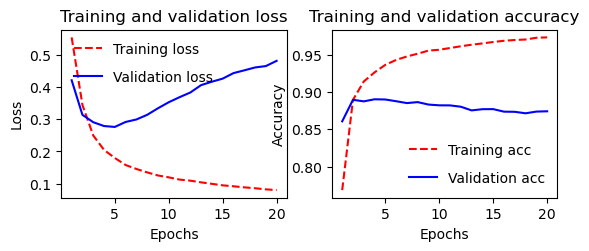

In [19]:
plot_loss_acc(M1_history)

In [20]:
M1_val_loss = M1_history["val_loss"]
M1_val_acc = M1_history["val_accuracy"]
M1_min_loss = format(min(M1_val_loss),'.3f')
M1_max_acc = format(max(M1_val_acc),'.3f')

In [21]:
#results = model.evaluate(x_test, y_test, verbose=0)

#print(f"loss: {results[0]}, accuracy: {results[1]}") 
#loss: 0.5069541931152344, accuracy: 0.8574800491333008

### Observation and comments

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1     |2       |16       |0.001  |0.0  |n/a  |n/a |n/a     |512|{{M1_min_loss}}      |{{M1_max_acc}}        |
  

It can be seen that on model M1, the minimum validation loss and the maximum validation accuracy are reached at the 5th ephoch. This indicates that this model is an overfitting model and is eligible for tuning.

In [22]:
#%tensorboard --logdir logs/fit

## Hyperparameter tunning

### Adjust learning rate

Learning rate determines the step size at each iteration while moving toward a minimum of a loss function, i.e, gradient descent. By default, Keras provides a default value 0.001 for the learning rate for its optimizers. Here choose 3 different parameter to set learning rate include learning rate decay.

* lr=0.005
* lr=0.0005
* lr=lr_schedule

#### M2a: learning rate = 0.005

In [23]:
model = imdb_model(16,16,1,0.005,0.,0., 0 , None, None)
M2a_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:26:33.025096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


29/30 [============================>.] - ETA: 0s - loss: 0.5749 - accuracy: 0.6679

2022-11-13 22:26:33.725951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 25ms/step - loss: 0.5732 - accuracy: 0.6690 - val_loss: 0.4231 - val_accuracy: 0.8108
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3871 - accuracy: 0.8325 - val_loss: 0.3477 - val_accuracy: 0.8586
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.3022 - accuracy: 0.8771 - val_loss: 0.3229 - val_accuracy: 0.8724
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2474 - accuracy: 0.9025 - val_loss: 0.3664 - val_accuracy: 0.8701
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2157 - accuracy: 0.9197 - val_loss: 0.3964 - val_accuracy: 0.8692
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2030 - accuracy: 0.9279 - val_loss: 0.4190 - val_accuracy: 0.8709
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1744 - accuracy: 0.9367 - val_loss: 0.4479 - val_accuracy: 0.8711
Epoch 8/20
30/30 [======

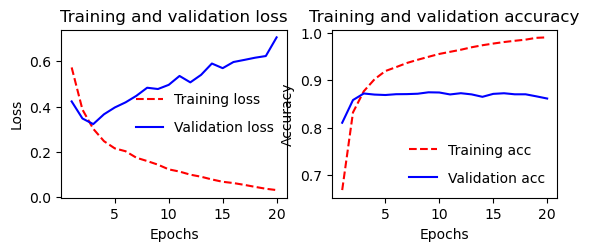

In [24]:
plot_loss_acc(M2a_history)

In [25]:
M2a_val_loss = M2a_history["val_loss"]
M2a_val_acc = M2a_history["val_accuracy"]
M2a_min_loss = format(min(M2a_val_loss),'.3f')
M2a_max_acc = format(max(M2a_val_acc),'.3f')

In [26]:
def val_loss_compare(m1,m2):
    
    epochs = range(1, len(m1) + 1)
    plt.plot(epochs, m1, "--r", label="Validation loss of the first")
    plt.plot(epochs, m2, "--b", label="Validation loss of the second") 
    plt.title("Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    plt.show()

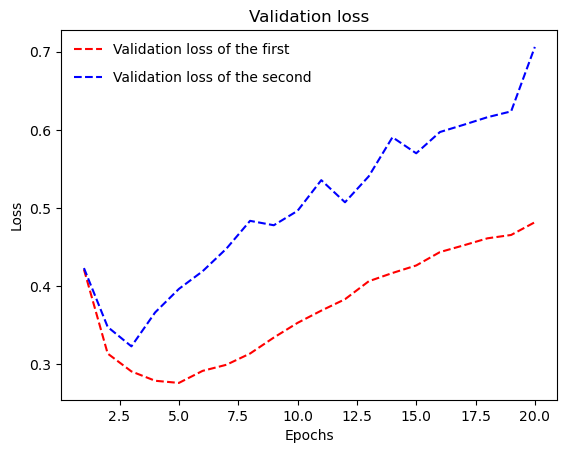

In [27]:
val_loss_compare(M1_val_loss,M2a_val_loss)

#### M2b: learning rate = 0.0005

In [28]:
model = imdb_model(16,16,1,0.0005, 0.,0., 0 , None, None)
M2b_history = train(20,512,0.4).history

Epoch 1/20
 1/30 [>.............................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5117

2022-11-13 22:26:42.502083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 24ms/step - loss: 0.6507 - accuracy: 0.6393 - val_loss: 0.5797 - val_accuracy: 0.8089
Epoch 2/20


2022-11-13 22:26:43.176423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 13ms/step - loss: 0.5080 - accuracy: 0.8459 - val_loss: 0.4541 - val_accuracy: 0.8599
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3904 - accuracy: 0.8863 - val_loss: 0.3748 - val_accuracy: 0.8764
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3120 - accuracy: 0.9028 - val_loss: 0.3236 - val_accuracy: 0.8848
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2605 - accuracy: 0.9169 - val_loss: 0.2952 - val_accuracy: 0.8885
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2242 - accuracy: 0.9267 - val_loss: 0.2802 - val_accuracy: 0.8895
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1988 - accuracy: 0.9339 - val_loss: 0.2761 - val_accuracy: 0.8918
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1799 - accuracy: 0.9378 - val_loss: 0.2747 - val_accuracy: 0.8923
Epoch 9/20
30/30 [======

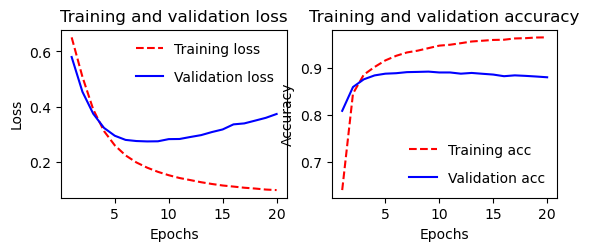

In [29]:
plot_loss_acc(M2b_history)

In [30]:
M2b_val_loss = M2b_history["val_loss"]
M2b_val_acc = M2b_history["val_accuracy"]
M2b_min_loss = format(min(M2b_val_loss),'.3f')
M2b_max_acc = format(max(M2b_val_acc),'.3f')

In [31]:
def val_loss_compare(m1,m2):
    
    epochs = range(1, len(m1) + 1)
    plt.plot(epochs, m1, "--r", label="Validation loss of the first")
    plt.plot(epochs, m2, "--b", label="Validation loss of the second") 
    plt.title("Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1)

    plt.show()

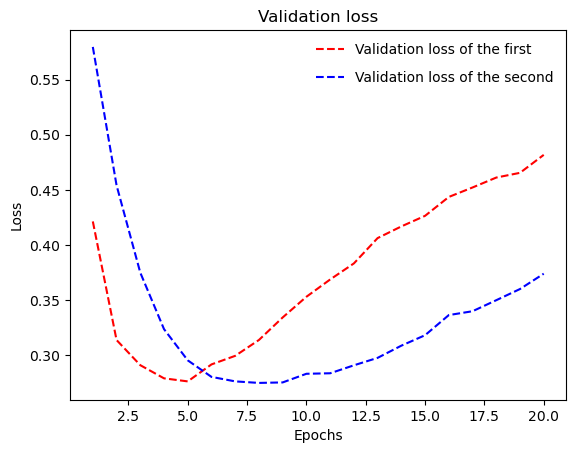

In [32]:
val_loss_compare(M1_val_loss,M2b_val_loss)

#### M2c: learning rate: decrease linearly 

Decrease the learning rate linearly from a large initial value to a small value.

In [33]:
STEPS_PER_EPOCH = len(train_data)//512

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

model = imdb_model(16,16,1,lr_schedule,0.,0., 0 , None, None)
M2c_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:26:51.332452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7691

2022-11-13 22:26:52.001025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 23ms/step - loss: 0.5473 - accuracy: 0.7691 - val_loss: 0.4194 - val_accuracy: 0.8612
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3411 - accuracy: 0.8901 - val_loss: 0.3125 - val_accuracy: 0.8873
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2433 - accuracy: 0.9168 - val_loss: 0.2911 - val_accuracy: 0.8886
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2024 - accuracy: 0.9289 - val_loss: 0.2793 - val_accuracy: 0.8903
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1781 - accuracy: 0.9377 - val_loss: 0.2797 - val_accuracy: 0.8884
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1568 - accuracy: 0.9428 - val_loss: 0.3027 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1459 - accuracy: 0.9479 - val_loss: 0.2992 - val_accuracy: 0.8856
Epoch 8/20
30/30 [======

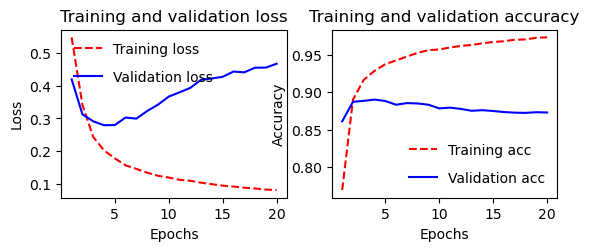

In [34]:
plot_loss_acc(M2c_history)

In [35]:
M2c_val_loss = M2c_history["val_loss"]
M2c_val_acc = M2c_history["val_accuracy"]
M2c_min_loss = format(min(M2c_val_loss),'.3f')
M2c_max_acc = format(max(M2c_val_acc),'.3f')

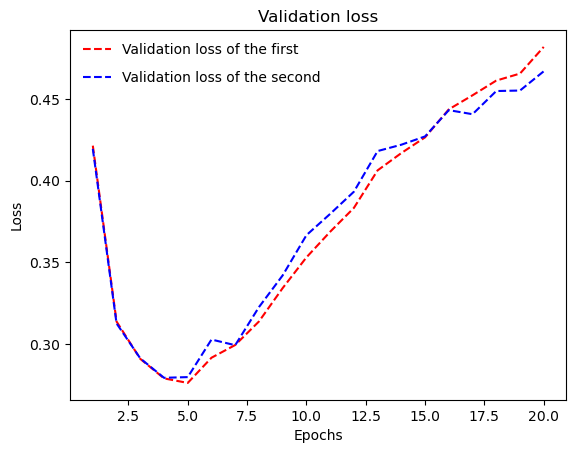

In [36]:
val_loss_compare(M1_val_loss,M2c_val_loss)

#### Observation and comments

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2       |16      |0.001  |0.0  |n/a  |n/a |n/a  |512  |{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2       |16      |0.005  |0.0  |n/a  |n/a |n/a  |512  |{{M2a_min_loss}}|{{M2a_max_acc}}|
|<mark>M2b<mark>    |2       |16     |0.0005 |0.0  |n/a  |n/a |n/a  |512 |<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c     |2       |16       |schedual |0.0  |n/a  |n/a |n/a |512     |{{M2c_min_loss}}|{{M2c_max_acc}}|

When lr = 0.005(M2a), it oscillates back and forth, unable to converge, and its validation loss is much more higher than its training loss.

When lr = 0.0005(M2b), the curve of verification loss is more flattened than the former, and the min of the validation loss is much lower. In fact, it reaches its minmum later than the M1 model.

When lr = lr_schedual which decrease linearly over epochs, the validation loss reaches its minmun around the similar position with the M1 model's.


When the other parameters remain the same, a lower learning rate can increase the model's accuray but it also means more training time and more expensive, or stuck itself in the local minumum. 



### Tweak momentum


The gradient descent with momentum borrows ideas from physics. It means it won't stop at the bottom, instead it rolls back and forth. This implementation of RMSprop uses plain momentum, with enough momentum, the ball won’t get
stuck in a ravine might have more chance to end up at the global minimum. 

Here choose 3 different value to test the influence of momentum.
* momentum = 0.9
* momentum = 0.5
* momentum = 0.7

#### M3a: momentum = 0.9

In [37]:
model = imdb_model(16,16,1,0.001,0.9,0., 0 , None, None)
M3a_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:00.281382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 21ms/step - loss: 0.5066 - accuracy: 0.7806 - val_loss: 0.3809 - val_accuracy: 0.8719
Epoch 2/20
 1/30 [>.............................] - ETA: 0s - loss: 0.3639 - accuracy: 0.8887

2022-11-13 22:27:01.142366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 13ms/step - loss: 0.3002 - accuracy: 0.9073 - val_loss: 0.3013 - val_accuracy: 0.8884
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2180 - accuracy: 0.9309 - val_loss: 0.3014 - val_accuracy: 0.8780
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1756 - accuracy: 0.9421 - val_loss: 0.2947 - val_accuracy: 0.8815
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1430 - accuracy: 0.9545 - val_loss: 0.2805 - val_accuracy: 0.8897
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1198 - accuracy: 0.9621 - val_loss: 0.3381 - val_accuracy: 0.8722
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1005 - accuracy: 0.9695 - val_loss: 0.3124 - val_accuracy: 0.8861
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0825 - accuracy: 0.9761 - val_loss: 0.3379 - val_accuracy: 0.8808
Epoch 9/20
30/30 [======

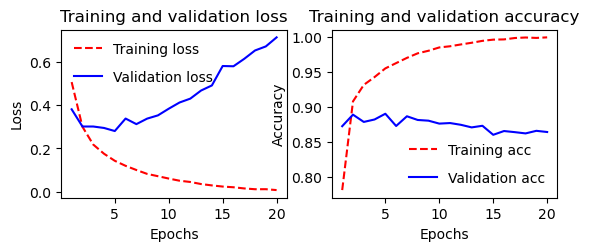

In [38]:
plot_loss_acc(M3a_history)

In [39]:
M3a_val_loss = M3a_history["val_loss"]
M3a_val_acc = M3a_history["val_accuracy"]
M3a_min_loss = format(min(M3a_val_loss),'.3f')
M3a_max_acc = format(max(M3a_val_acc),'.3f')

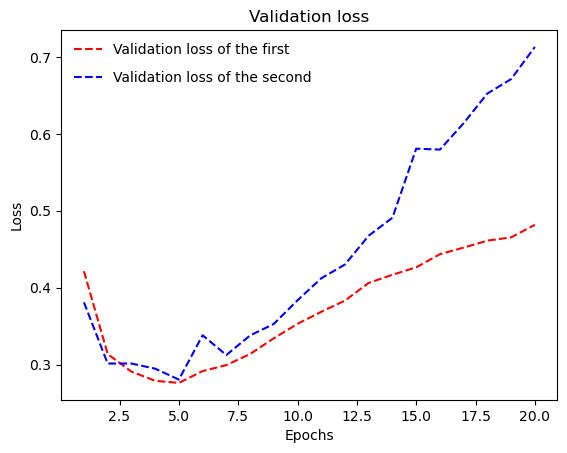

In [40]:
val_loss_compare(M1_val_loss,M3a_val_loss)

#### M3b: momentum = 0.5

In [41]:
model = imdb_model(16,16,1,0.001,0.5,0., 0 , None, None)
M3b_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:09.151553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 22ms/step - loss: 0.5483 - accuracy: 0.7763 - val_loss: 0.4261 - val_accuracy: 0.8587
Epoch 2/20
 1/30 [>.............................] - ETA: 0s - loss: 0.4222 - accuracy: 0.8652

2022-11-13 22:27:09.820166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 14ms/step - loss: 0.3434 - accuracy: 0.8931 - val_loss: 0.3158 - val_accuracy: 0.8874
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2465 - accuracy: 0.9191 - val_loss: 0.2815 - val_accuracy: 0.8932
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1930 - accuracy: 0.9363 - val_loss: 0.2820 - val_accuracy: 0.8879
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1635 - accuracy: 0.9446 - val_loss: 0.2751 - val_accuracy: 0.8912
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1386 - accuracy: 0.9535 - val_loss: 0.2933 - val_accuracy: 0.8863
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1221 - accuracy: 0.9590 - val_loss: 0.3098 - val_accuracy: 0.8822
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1067 - accuracy: 0.9665 - val_loss: 0.3073 - val_accuracy: 0.8849
Epoch 9/20
30/30 [======

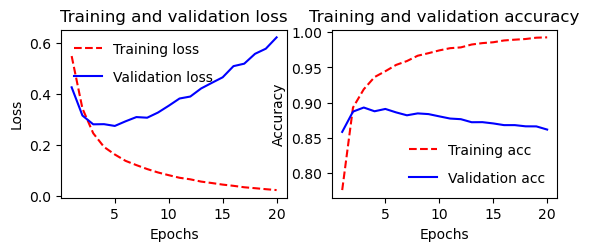

In [42]:
plot_loss_acc(M3b_history)

In [43]:
M3b_val_loss = M3b_history["val_loss"]
M3b_val_acc = M3b_history["val_accuracy"]
M3b_min_loss = format(min(M3b_val_loss),'.3f')
M3b_max_acc = format(max(M3b_val_acc),'.3f')

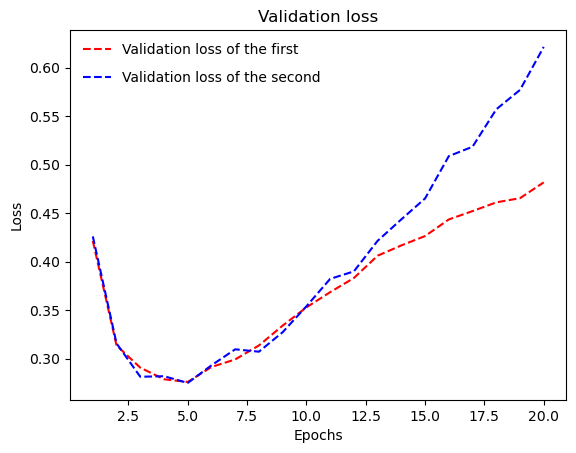

In [44]:
val_loss_compare(M1_val_loss,M3b_val_loss)

#### M3c: momentum = 0.7

In [45]:
model = imdb_model(16,16,1,0.001,0.7,0., 0 , None, None)
M3c_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:18.008344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 23ms/step - loss: 0.5813 - accuracy: 0.7318 - val_loss: 0.4718 - val_accuracy: 0.8144
Epoch 2/20


2022-11-13 22:27:18.712052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 13ms/step - loss: 0.3695 - accuracy: 0.8874 - val_loss: 0.3309 - val_accuracy: 0.8849
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2558 - accuracy: 0.9167 - val_loss: 0.2893 - val_accuracy: 0.8906
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1986 - accuracy: 0.9369 - val_loss: 0.2904 - val_accuracy: 0.8850
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1663 - accuracy: 0.9471 - val_loss: 0.2742 - val_accuracy: 0.8933
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1382 - accuracy: 0.9560 - val_loss: 0.2829 - val_accuracy: 0.8894
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1200 - accuracy: 0.9613 - val_loss: 0.3067 - val_accuracy: 0.8828
Epoch 8/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1025 - accuracy: 0.9683 - val_loss: 0.3110 - val_accuracy: 0.8835
Epoch 9/20
30/30 [======

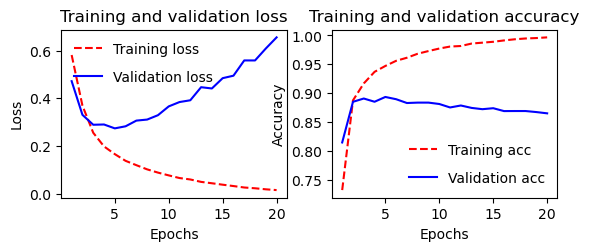

In [46]:
plot_loss_acc(M3c_history)

In [47]:
M3c_val_loss = M3c_history["val_loss"]
M3c_val_acc = M3c_history["val_accuracy"]
M3c_min_loss = format(min(M3c_val_loss),'.3f')
M3c_max_acc = format(max(M3c_val_acc),'.3f')

#### Observation and comments

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2     |16       |0.005  |0.0  |n/a  |n/a |n/a   |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|<mark>M2b<mark>|2   |16  |0.0005 |0.0  |n/a |n/a |n/a|512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2     |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2     |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|<mark>M3b<mark>   |2   |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|<mark>M3c<mark>   |2     |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|<mark>{{M3c_min_loss}}<mark>|<mark>{{M3c_max_acc}}<mark>|

When momentum = 0.9 and 0.7, the curve of validation loss increase rapidly after it reaches its minimun.

When momentum = 0.5(M3b), the validation loss curve is relatively smoother than the others, and reach to the min later than the M1 model, also, the minmun validation loss is smaller then M1.

### Add dropout layers

Dropout is a technique where randomly selected neurons are ignored during training, it helps prevent overfitting. Unlike L1 and L2 regularization, dropout doesn't modify the cost function. Instead, it modify the network itself by adding dropout layers.

Here choose three dropout rate to compare:
- dropout rate = 0.5
- dropout rate = 0.25
- dropout rate = 0.37

#### M4a: dropout rate = 0.5

In [48]:
model = imdb_model(16,16,1,0.001,0.0,0.5, 0 , None, None)
M4a_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:27.021500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.6185

2022-11-13 22:27:27.771956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 25ms/step - loss: 0.6495 - accuracy: 0.6185 - val_loss: 0.5586 - val_accuracy: 0.8038
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5287 - accuracy: 0.7534 - val_loss: 0.4362 - val_accuracy: 0.8622
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4379 - accuracy: 0.8223 - val_loss: 0.3615 - val_accuracy: 0.8767
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3717 - accuracy: 0.8562 - val_loss: 0.3255 - val_accuracy: 0.8843
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3323 - accuracy: 0.8796 - val_loss: 0.2974 - val_accuracy: 0.8911
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3057 - accuracy: 0.8922 - val_loss: 0.2857 - val_accuracy: 0.8947
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2823 - accuracy: 0.9058 - val_loss: 0.2870 - val_accuracy: 0.8889
Epoch 8/20
30/30 [======

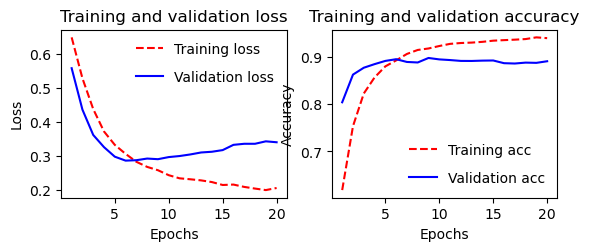

In [49]:
plot_loss_acc(M4a_history)

In [50]:
M4a_val_loss = M4a_history["val_loss"]
M4a_val_acc = M4a_history["val_accuracy"]
M4a_min_loss = format(min(M4a_val_loss),'.3f')
M4a_max_acc = format(max(M4a_val_acc),'.3f')

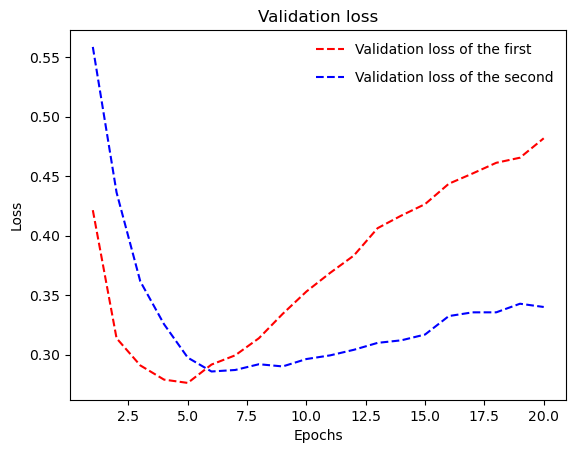

In [51]:
val_loss_compare(M1_val_loss,M4a_val_loss)

#### M4b: dropout rate = 0.25

In [52]:
model = imdb_model(16,16,1,0.001,0.0,0.25, 0 , None, None)
M4b_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:36.576957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6825

2022-11-13 22:27:37.319441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 25ms/step - loss: 0.6147 - accuracy: 0.6825 - val_loss: 0.4803 - val_accuracy: 0.8508
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4304 - accuracy: 0.8337 - val_loss: 0.3456 - val_accuracy: 0.8806
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3261 - accuracy: 0.8826 - val_loss: 0.2932 - val_accuracy: 0.8906
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2657 - accuracy: 0.9064 - val_loss: 0.2803 - val_accuracy: 0.8922
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2298 - accuracy: 0.9197 - val_loss: 0.2751 - val_accuracy: 0.8934
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2087 - accuracy: 0.9280 - val_loss: 0.2857 - val_accuracy: 0.8941
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1878 - accuracy: 0.9330 - val_loss: 0.3125 - val_accuracy: 0.8882
Epoch 8/20
30/30 [======

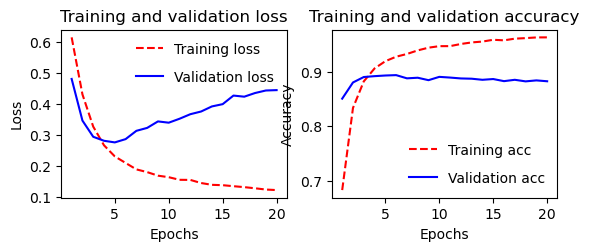

In [53]:
plot_loss_acc(M4b_history)

In [54]:
M4b_val_loss = M4b_history["val_loss"]
M4b_val_acc = M4b_history["val_accuracy"]
M4b_min_loss = format(min(M4b_val_loss),'.3f')
M4b_max_acc = format(max(M4b_val_acc),'.3f')

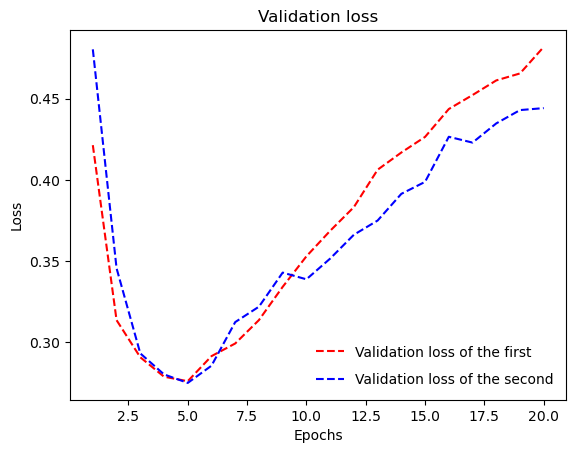

In [55]:
val_loss_compare(M1_val_loss,M4b_val_loss)

#### M4c: dropout rate = 0.37

In [56]:
model = imdb_model(16,16,1,0.001,0.0,0.37, 0 , None, None)
M4c_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:46.051286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6167

2022-11-13 22:27:46.796942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 26ms/step - loss: 0.6404 - accuracy: 0.6167 - val_loss: 0.5448 - val_accuracy: 0.7830
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.5068 - accuracy: 0.7819 - val_loss: 0.4294 - val_accuracy: 0.8690
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4098 - accuracy: 0.8342 - val_loss: 0.3681 - val_accuracy: 0.8751
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3471 - accuracy: 0.8703 - val_loss: 0.3370 - val_accuracy: 0.8806
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3082 - accuracy: 0.8883 - val_loss: 0.3157 - val_accuracy: 0.8819
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2838 - accuracy: 0.9024 - val_loss: 0.3099 - val_accuracy: 0.8835
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2617 - accuracy: 0.9124 - val_loss: 0.3094 - val_accuracy: 0.8859
Epoch 8/20
30/30 [======

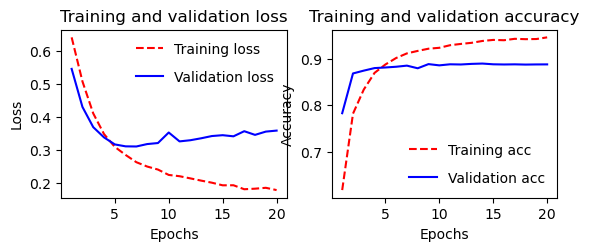

In [57]:
plot_loss_acc(M4c_history)

In [58]:
M4c_val_loss = M4c_history["val_loss"]
M4c_val_acc = M4c_history["val_accuracy"]
M4c_min_loss = format(min(M4c_val_loss),'.3f')
M4c_max_acc = format(max(M4c_val_acc),'.3f')

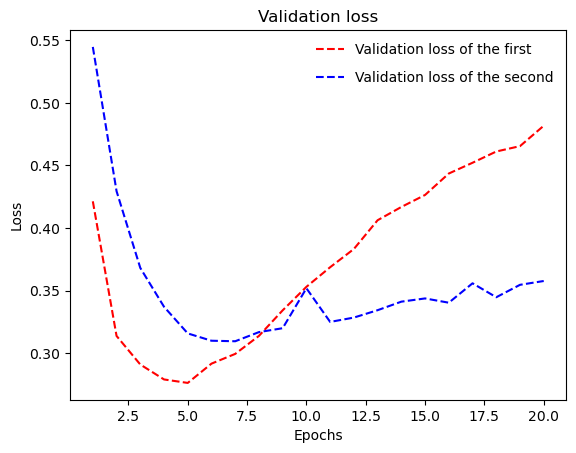

In [59]:
val_loss_compare(M1_val_loss,M4c_val_loss)

#### Observation and comments

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2     |16       |0.005  |0.0  |n/a  |n/a |n/a   |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|<mark>M2b<mark>|2   |16  |0.0005 |0.0  |n/a |n/a |n/a|512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2     |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2     |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|<mark>M3b<mark>   |2   |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|<mark>M3c<mark>   |2     |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|<mark>{{M3c_min_loss}}<mark>|<mark>{{M3c_max_acc}}<mark>|
|M4a   |2       |16       |0.001 |0.0  |n/a  |n/a |0.5  |512|{{M4a_min_loss}}|{{M4a_max_acc}}|
|<mark>M4b<mark>   |2       |16       |0.001 |0.0  |n/a  |n/a |0.25|512 |<mark>{{M4b_min_loss}}<mark>|<mark>{{M4b_max_acc}}<mark>|
|M4c   |2       |16       |0.001 |0.0  |n/a  |n/a |0.37|512|{{M4c_min_loss}}|{{M4c_max_acc}}|

When dropout rate = 0.5(M4a), the minimum of validation loss gets much higher, however, the rapid growth curve has been restrained. Try a lower number to get similar result but better min validation loss.

When dropout rate = 0.25, the minimum validation loss is getting better but the maximum of validation accuracy is decreased.

When dropout rate = 0.37, the max accuracy of validation is increased, so as the min validation loss.

These three model's validation loss reaches its minimum later than its training loss and the M1 model's validation loss, and they all suppress the curve from increasing sharply.

### Regularized regression

To reduce the complexity of the model and avoid overfitting, L1 or L2 regularized regression can be applied to shrink unimportant regression coefficients towards zero.


L1, also called a lasso regression, adds the “absolute value of magnitude” of the coefficient as a penalty term to the loss function. L2, adds an L2 penalty which is the square of the magnitude of coefficients. L1 and L2 could be combined to use. For example, l2(1e-5) means that each coefficient of this layer's weight matrix increases the total network loss by 1e-5 * weight_ coefficient_value. Since this penalty is only added at training time, the training loss of this network will be be much larger than the test loss.

Here choose three values for each regularization method.

- reg_type = regularizers.l1, reg_val = 1e-3
- reg_type = regularizers.l2, reg_val = 1e-3
- reg_type = regularizers.l1_l2, reg_val = 1e-3


- reg_type = regularizers.l1, reg_val = 1e-4
- reg_type = regularizers.l2, reg_val = 1e-4
- reg_type = regularizers.l1_l2, reg_val = 1e-4


- reg_type = regularizers.l1, reg_val = 1e-5
- reg_type = regularizers.l2, reg_val = 1e-5
- reg_type = regularizers.l1_l2, reg_val = 1e-5

#### M5a: L1(1e-3) 

In [60]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1, reg_val = 0.001)
M5a_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:27:55.428803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 1.3646 - accuracy: 0.7133

2022-11-13 22:27:56.170710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 25ms/step - loss: 1.3646 - accuracy: 0.7133 - val_loss: 0.7693 - val_accuracy: 0.8164
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.7331 - accuracy: 0.8141 - val_loss: 0.6968 - val_accuracy: 0.8467
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6755 - accuracy: 0.8405 - val_loss: 0.6641 - val_accuracy: 0.8402
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6436 - accuracy: 0.8483 - val_loss: 0.6379 - val_accuracy: 0.8487
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.6239 - accuracy: 0.8523 - val_loss: 0.6199 - val_accuracy: 0.8496
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.6085 - accuracy: 0.8560 - val_loss: 0.6056 - val_accuracy: 0.8550
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.5998 - accuracy: 0.8541 - val_loss: 0.5961 - val_accuracy: 0.8569
Epoch 8/20
30/30 [======

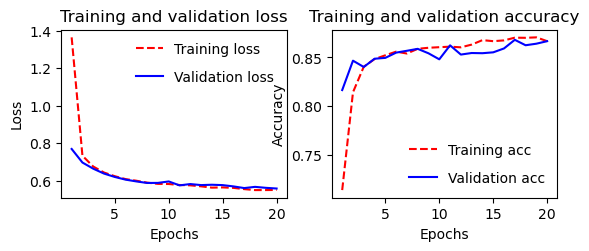

In [61]:
plot_loss_acc(M5a_history)

In [62]:
M5a_val_loss = M5a_history["val_loss"]
M5a_val_acc = M5a_history["val_accuracy"]
M5a_min_loss = format(min(M5a_val_loss),'.3f')
M5a_max_acc = format(max(M5a_val_acc),'.3f')

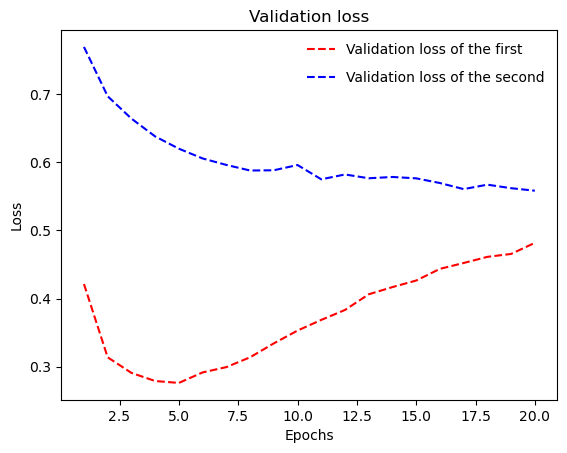

In [63]:
val_loss_compare(M1_val_loss,M5a_val_loss)

#### M5b: L2(1e-3)

In [64]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l2, reg_val = 0.001)
M5b_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:28:04.837245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.7552

2022-11-13 22:28:05.612535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 28ms/step - loss: 0.6198 - accuracy: 0.7552 - val_loss: 0.5016 - val_accuracy: 0.8445
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.4277 - accuracy: 0.8801 - val_loss: 0.3844 - val_accuracy: 0.8779
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.3379 - accuracy: 0.8953 - val_loss: 0.3544 - val_accuracy: 0.8768
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.3026 - accuracy: 0.9066 - val_loss: 0.3359 - val_accuracy: 0.8838
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2866 - accuracy: 0.9103 - val_loss: 0.3293 - val_accuracy: 0.8849
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2757 - accuracy: 0.9144 - val_loss: 0.3371 - val_accuracy: 0.8791
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2688 - accuracy: 0.9147 - val_loss: 0.3275 - val_accuracy: 0.8815
Epoch 8/20
30/30 [======

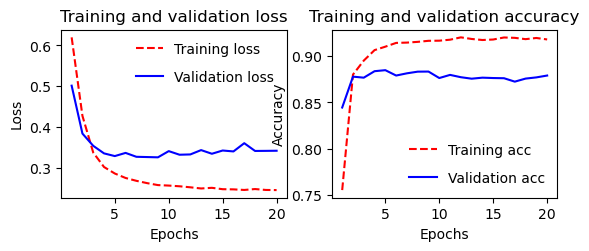

In [65]:
plot_loss_acc(M5b_history)

In [66]:
M5b_val_loss = M5b_history["val_loss"]
M5b_val_acc = M5b_history["val_accuracy"]
M5b_min_loss = format(min(M5b_val_loss),'.3f')
M5b_max_acc = format(max(M5b_val_acc),'.3f')

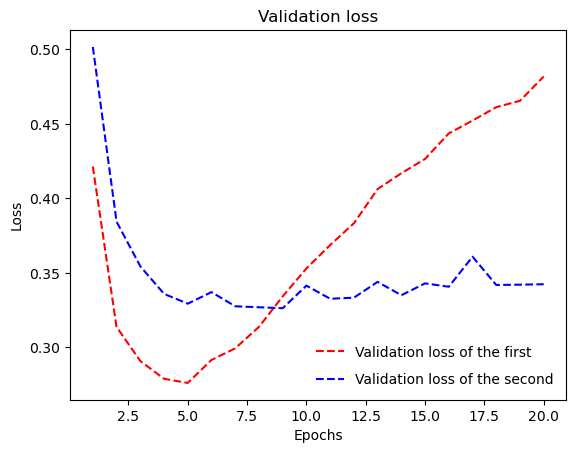

In [67]:
val_loss_compare(M1_val_loss,M5b_val_loss)

#### M5c: L1_L2(1e-3) 

In [68]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1_l2, reg_val = 0.001)
M5c_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:28:16.197622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 1.5575 - accuracy: 0.6751

2022-11-13 22:28:17.129852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 32ms/step - loss: 1.5575 - accuracy: 0.6751 - val_loss: 0.8940 - val_accuracy: 0.8199
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.8521 - accuracy: 0.8151 - val_loss: 0.8147 - val_accuracy: 0.8235
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.7816 - accuracy: 0.8321 - val_loss: 0.7587 - val_accuracy: 0.8398
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.7334 - accuracy: 0.8422 - val_loss: 0.7263 - val_accuracy: 0.8311
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.7008 - accuracy: 0.8433 - val_loss: 0.6935 - val_accuracy: 0.8452
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6748 - accuracy: 0.8477 - val_loss: 0.6755 - val_accuracy: 0.8428
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.6523 - accuracy: 0.8521 - val_loss: 0.6493 - val_accuracy: 0.8489
Epoch 8/20
30/30 [======

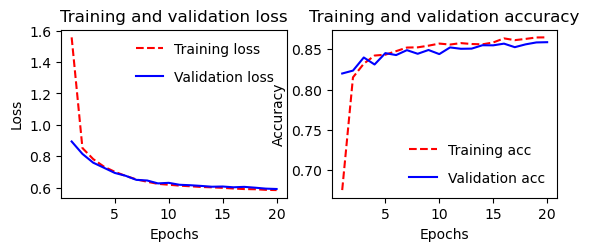

In [69]:
plot_loss_acc(M5c_history)

In [70]:
M5c_val_loss = M5c_history["val_loss"]
M5c_val_acc = M5c_history["val_accuracy"]
M5c_min_loss = format(min(M5c_val_loss),'.3f')
M5c_max_acc = format(max(M5c_val_acc),'.3f')

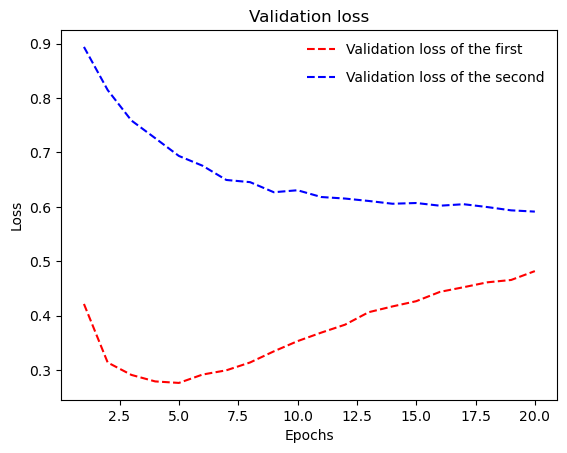

In [71]:
val_loss_compare(M1_val_loss,M5c_val_loss)

#### M5d: L1(1e-4)

In [72]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1, reg_val = 0.0001)
M5d_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:28:28.391013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7691

2022-11-13 22:28:29.222512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 26ms/step - loss: 0.6941 - accuracy: 0.7691 - val_loss: 0.5357 - val_accuracy: 0.8540
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4676 - accuracy: 0.8765 - val_loss: 0.4217 - val_accuracy: 0.8786
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3819 - accuracy: 0.8913 - val_loss: 0.3895 - val_accuracy: 0.8785
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3473 - accuracy: 0.8994 - val_loss: 0.3678 - val_accuracy: 0.8830
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3308 - accuracy: 0.9034 - val_loss: 0.3597 - val_accuracy: 0.8838
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3187 - accuracy: 0.9059 - val_loss: 0.3614 - val_accuracy: 0.8789
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3104 - accuracy: 0.9086 - val_loss: 0.3538 - val_accuracy: 0.8863
Epoch 8/20
30/30 [======

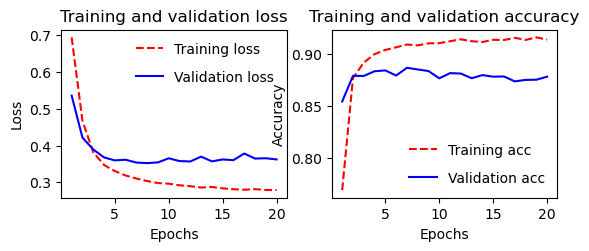

In [73]:
plot_loss_acc(M5d_history)

In [74]:
M5d_val_loss = M5d_history["val_loss"]
M5d_val_acc = M5d_history["val_accuracy"]
M5d_min_loss = format(min(M5d_val_loss),'.3f')
M5d_max_acc = format(max(M5d_val_acc),'.3f')

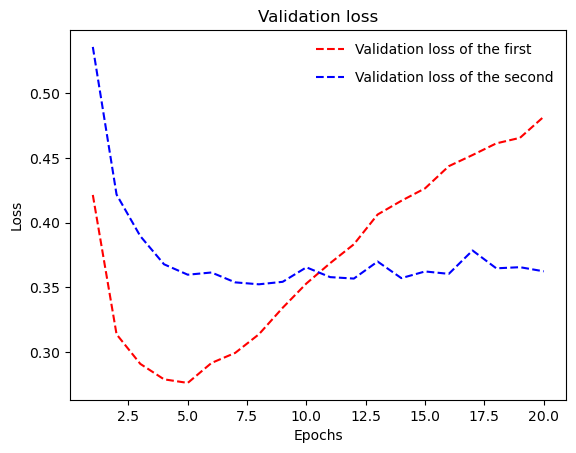

In [75]:
val_loss_compare(M1_val_loss,M5d_val_loss)

#### M5e: L2(1e-4)

In [76]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l2, reg_val = 0.0001)
M5e_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:28:37.657379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.7037

2022-11-13 22:28:38.505258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 29ms/step - loss: 0.6053 - accuracy: 0.7037 - val_loss: 0.4915 - val_accuracy: 0.8581
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4117 - accuracy: 0.8759 - val_loss: 0.3551 - val_accuracy: 0.8806
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.3047 - accuracy: 0.9011 - val_loss: 0.3168 - val_accuracy: 0.8815
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2596 - accuracy: 0.9140 - val_loss: 0.2958 - val_accuracy: 0.8864
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2381 - accuracy: 0.9187 - val_loss: 0.2880 - val_accuracy: 0.8899
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2215 - accuracy: 0.9221 - val_loss: 0.2968 - val_accuracy: 0.8840
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2123 - accuracy: 0.9243 - val_loss: 0.2895 - val_accuracy: 0.8864
Epoch 8/20
30/30 [======

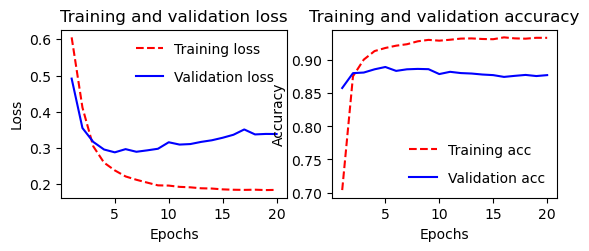

In [77]:
plot_loss_acc(M5e_history)

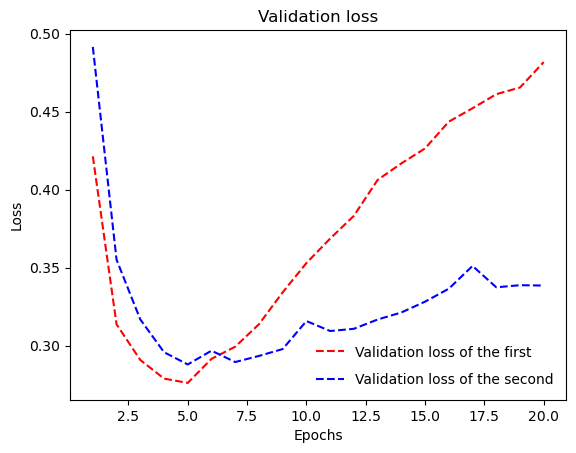

In [78]:
M5e_val_loss = M5e_history["val_loss"]
M5e_val_acc = M5e_history["val_accuracy"]
M5e_min_loss = format(min(M5e_val_loss),'.3f')
M5e_max_acc = format(max(M5e_val_acc),'.3f')
val_loss_compare(M1_val_loss,M5e_val_loss)

#### M5f: L1_L2(1e-4)

In [79]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1_l2, reg_val = 0.0001)
M5f_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:28:49.319117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.9642 - accuracy: 0.7343

2022-11-13 22:28:50.252003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 31ms/step - loss: 0.9642 - accuracy: 0.7343 - val_loss: 0.7381 - val_accuracy: 0.8268
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6831 - accuracy: 0.8589 - val_loss: 0.6320 - val_accuracy: 0.8716
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5992 - accuracy: 0.8759 - val_loss: 0.5877 - val_accuracy: 0.8660
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5591 - accuracy: 0.8785 - val_loss: 0.5523 - val_accuracy: 0.8722
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5344 - accuracy: 0.8813 - val_loss: 0.5373 - val_accuracy: 0.8731
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.5181 - accuracy: 0.8806 - val_loss: 0.5196 - val_accuracy: 0.8748
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.5070 - accuracy: 0.8813 - val_loss: 0.5130 - val_accuracy: 0.8749
Epoch 8/20
30/30 [======

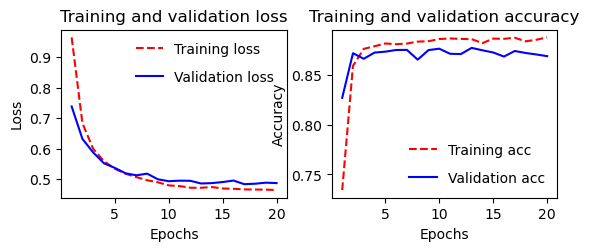

In [80]:
plot_loss_acc(M5f_history)

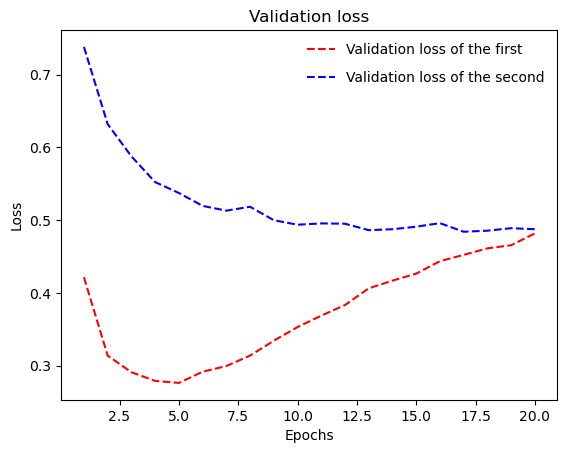

In [81]:
M5f_val_loss = M5f_history["val_loss"]
M5f_val_acc = M5f_history["val_accuracy"]
M5f_min_loss = format(min(M5f_val_loss),'.3f')
M5f_max_acc = format(max(M5f_val_acc),'.3f')
val_loss_compare(M1_val_loss,M5f_val_loss)

#### M5g: L1(1e-5)

In [82]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1, reg_val = 1e-5)
M5g_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:29:01.256467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7664

2022-11-13 22:29:02.039650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 26ms/step - loss: 0.5809 - accuracy: 0.7664 - val_loss: 0.4561 - val_accuracy: 0.8589
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3845 - accuracy: 0.8821 - val_loss: 0.3446 - val_accuracy: 0.8847
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2961 - accuracy: 0.9006 - val_loss: 0.3151 - val_accuracy: 0.8819
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2597 - accuracy: 0.9124 - val_loss: 0.2988 - val_accuracy: 0.8867
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2411 - accuracy: 0.9173 - val_loss: 0.2932 - val_accuracy: 0.8896
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2269 - accuracy: 0.9205 - val_loss: 0.3007 - val_accuracy: 0.8836
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2190 - accuracy: 0.9219 - val_loss: 0.2951 - val_accuracy: 0.8868
Epoch 8/20
30/30 [======

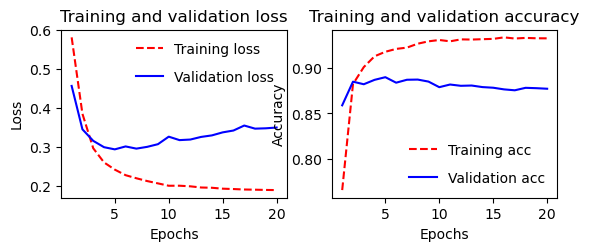

In [83]:
plot_loss_acc(M5g_history)

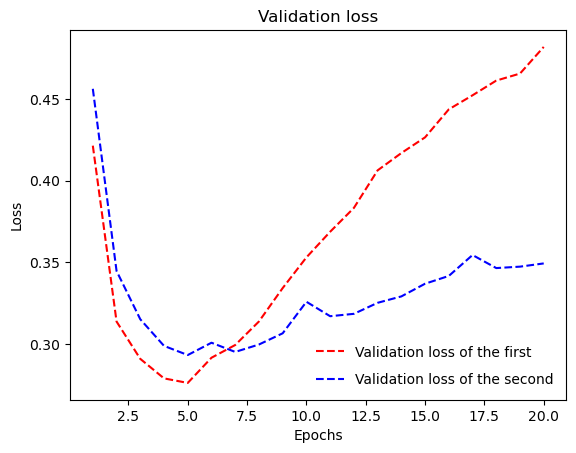

In [84]:
M5g_val_loss = M5g_history["val_loss"]
M5g_val_acc = M5g_history["val_accuracy"]
M5g_min_loss = format(min(M5g_val_loss),'.3f')
M5g_max_acc = format(max(M5g_val_acc),'.3f')
val_loss_compare(M1_val_loss,M5g_val_loss)

#### M5h: L2(1e-5)

In [85]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l2, reg_val = 1e-5)
M5h_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:29:10.512625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.7227

2022-11-13 22:29:11.574078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 29ms/step - loss: 0.5890 - accuracy: 0.7227 - val_loss: 0.4646 - val_accuracy: 0.8583
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3811 - accuracy: 0.8815 - val_loss: 0.3352 - val_accuracy: 0.8835
Epoch 3/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2795 - accuracy: 0.9033 - val_loss: 0.3019 - val_accuracy: 0.8857
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2374 - accuracy: 0.9175 - val_loss: 0.2847 - val_accuracy: 0.8901
Epoch 5/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2160 - accuracy: 0.9221 - val_loss: 0.2791 - val_accuracy: 0.8925
Epoch 6/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1989 - accuracy: 0.9279 - val_loss: 0.2924 - val_accuracy: 0.8842
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1893 - accuracy: 0.9304 - val_loss: 0.2894 - val_accuracy: 0.8868
Epoch 8/20
30/30 [======

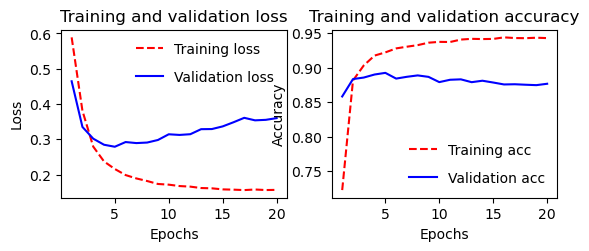

In [86]:
plot_loss_acc(M5h_history)

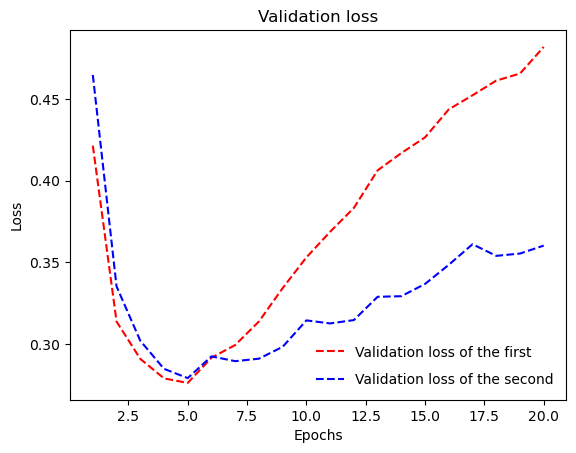

In [87]:
M5h_val_loss = M5h_history["val_loss"]
M5h_val_acc = M5h_history["val_accuracy"]
M5h_min_loss = format(min(M5h_val_loss),'.3f')
M5h_max_acc = format(max(M5h_val_acc),'.3f')
val_loss_compare(M1_val_loss,M5h_val_loss)

#### M5i: L1_L2(1e-5)

In [88]:
model = imdb_model(16,16,1,0.001,0.0,0., 1 , reg_type = regularizers.l1_l2, reg_val = 1e-5)
M5i_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:29:22.020105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.8802 - accuracy: 0.7579

2022-11-13 22:29:22.976616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 34ms/step - loss: 0.8802 - accuracy: 0.7579 - val_loss: 0.7010 - val_accuracy: 0.8483
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.6466 - accuracy: 0.8657 - val_loss: 0.6005 - val_accuracy: 0.8728
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5677 - accuracy: 0.8785 - val_loss: 0.5599 - val_accuracy: 0.8688
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5306 - accuracy: 0.8818 - val_loss: 0.5313 - val_accuracy: 0.8747
Epoch 5/20
30/30 [==============================] - 1s 17ms/step - loss: 0.5089 - accuracy: 0.8861 - val_loss: 0.5150 - val_accuracy: 0.8740
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.4911 - accuracy: 0.8849 - val_loss: 0.4971 - val_accuracy: 0.8757
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4779 - accuracy: 0.8861 - val_loss: 0.4874 - val_accuracy: 0.8759
Epoch 8/20
30/30 [======

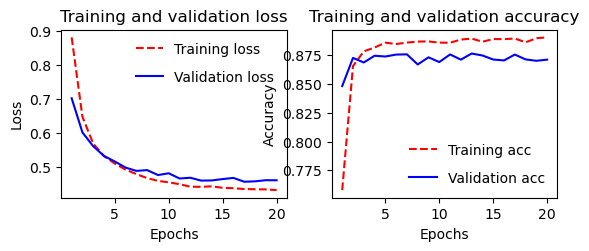

In [89]:
plot_loss_acc(M5i_history)

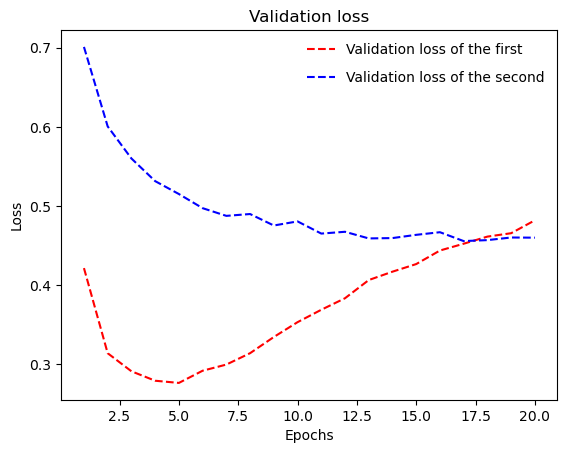

In [90]:
M5i_val_loss = M5i_history["val_loss"]
M5i_val_acc = M5i_history["val_accuracy"]
M5i_min_loss = format(min(M5i_val_loss),'.3f')
M5i_max_acc = format(max(M5i_val_acc),'.3f')
val_loss_compare(M1_val_loss,M5i_val_loss)

#### Observation and comments

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2     |16       |0.005  |0.0  |n/a  |n/a |n/a   |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|<mark>M2b<mark>|2   |16  |0.0005 |0.0  |n/a |n/a |n/a|512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2     |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2     |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|<mark>M3b<mark>   |2   |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|<mark>M3c<mark>   |2     |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|<mark>{{M3c_min_loss}}<mark>|<mark>{{M3c_max_acc}}<mark>|
|M4a   |2       |16       |0.001 |0.0  |n/a  |n/a |0.5  |512|{{M4a_min_loss}}|{{M4a_max_acc}}|
|<mark>M4b<mark>   |2       |16       |0.001 |0.0  |n/a  |n/a |0.25|512 |<mark>{{M4b_min_loss}}<mark>|<mark>{{M4b_max_acc}}<mark>|
|M4c   |2       |16       |0.001 |0.0  |n/a  |n/a |0.37|512|{{M4c_min_loss}}|{{M4c_max_acc}}|
|M5a   |2       |16       |0.001 |0.0  |0.001  |n/a |n/a|512|{{M5a_min_loss}}|{{M5a_max_acc}}|
|M5b   |2       |16       |0.001 |0.0  |n/a  |0.001 |n/a|512|{{M5b_min_loss}}|{{M5b_max_acc}}|
|M5c   |2       |16       |0.001 |0.0  |0.001  |0.001 |n/a|512|{{M5c_min_loss}}|{{M5c_max_acc}}|
|M5d   |2       |16       |0.001 |0.0  |0.0001  |n/a |n/a|512|{{M5d_min_loss}}|{{M5d_max_acc}}|
|M5e   |2       |16       |0.001 |0.0  |n/a  |0.0001 |n/a|512|{{M5e_min_loss}}|{{M5e_max_acc}}|
|M5f   |2       |16       |0.001 |0.0  |0.0001  |0.0001 |n/a|512|{{M5f_min_loss}}|{{M5f_max_acc}}|
|M5g   |2       |16       |0.001 |0.0  |0.00001  |n/a |n/a|512|{{M5g_min_loss}}|{{M5g_max_acc}}|
|<mark>M5h<mark>  |2       |16     |0.001 |0.0  |n/a  |0.00001|n/a|512|<mark>{{M5h_min_loss}}<mark>|<mark>{{M5h_max_acc}}<mark>|
|M5i   |2       |16       |0.001 |0.0  |0.00001  |0.00001|n/a|512|{{M5i_min_loss}}|{{M5i_max_acc}}|

The best minimun validation loss number is in M5h model, which is using 1e-5 and L2 regularization. 
In models M5a, M5c, M5f, M5i, their curves overlap on the training and validation sets shows that they're underfitting. M5b, M5d, M5e, M5g, M5h have healthier curves than the others.



### Change batch size

#### M6a: batch size = 256

In [91]:
model = imdb_model(16,16,1,0.001,0.,0., 0 , None, None)
M6a_history = train(20,256,0.4).history

Epoch 1/20


2022-11-13 22:29:34.064568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - ETA: 0s - loss: 0.5097 - accuracy: 0.7809

2022-11-13 22:29:34.995847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 1s 17ms/step - loss: 0.5097 - accuracy: 0.7809 - val_loss: 0.3500 - val_accuracy: 0.8789
Epoch 2/20
59/59 [==============================] - 1s 11ms/step - loss: 0.2761 - accuracy: 0.9003 - val_loss: 0.2802 - val_accuracy: 0.8909
Epoch 3/20
59/59 [==============================] - 1s 14ms/step - loss: 0.2128 - accuracy: 0.9231 - val_loss: 0.2859 - val_accuracy: 0.8895
Epoch 4/20
59/59 [==============================] - 1s 10ms/step - loss: 0.1904 - accuracy: 0.9299 - val_loss: 0.3033 - val_accuracy: 0.8894
Epoch 5/20
59/59 [==============================] - 1s 11ms/step - loss: 0.1772 - accuracy: 0.9354 - val_loss: 0.3108 - val_accuracy: 0.8909
Epoch 6/20
59/59 [==============================] - 1s 11ms/step - loss: 0.1701 - accuracy: 0.9375 - val_loss: 0.3272 - val_accuracy: 0.8869
Epoch 7/20
59/59 [==============================] - 1s 10ms/step - loss: 0.1630 - accuracy: 0.9409 - val_loss: 0.3427 - val_accuracy: 0.8856
Epoch 8/20
59/59 [======

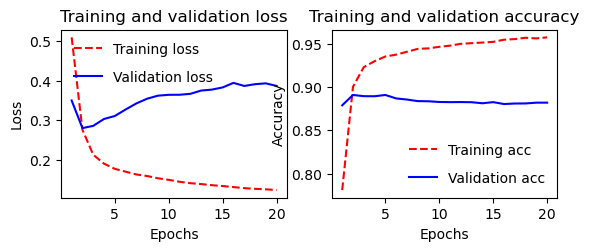

In [92]:
plot_loss_acc(M6a_history)

In [93]:
M6a_val_loss = M6a_history["val_loss"]
M6a_val_acc = M6a_history["val_accuracy"]
M6a_min_loss = format(min(M6a_val_loss),'.3f')
M6a_max_acc = format(max(M6a_val_acc),'.3f')

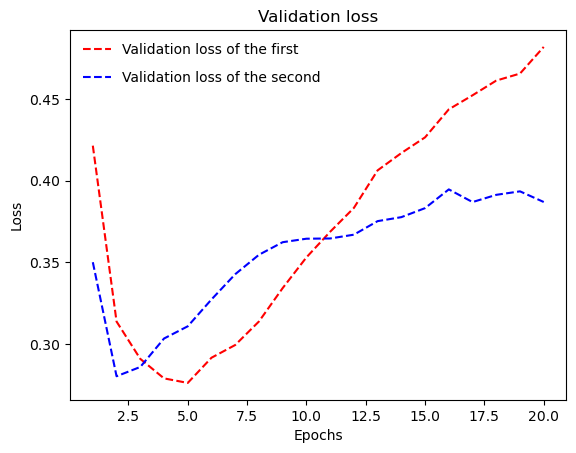

In [94]:
val_loss_compare(M1_val_loss,M6a_val_loss)

#### M6b: batch size = 768

In [95]:
model = imdb_model(16,16,1,0.001,0.,0., 0 , None, None)
M6b_history = train(20,768,0.4).history

Epoch 1/20


2022-11-13 22:29:47.823193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.7402

2022-11-13 22:29:48.550955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 35ms/step - loss: 0.6178 - accuracy: 0.7402 - val_loss: 0.5152 - val_accuracy: 0.8313
Epoch 2/20
20/20 [==============================] - 0s 16ms/step - loss: 0.4366 - accuracy: 0.8697 - val_loss: 0.3933 - val_accuracy: 0.8666
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 0.3225 - accuracy: 0.9028 - val_loss: 0.3235 - val_accuracy: 0.8820
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 0.2530 - accuracy: 0.9191 - val_loss: 0.2936 - val_accuracy: 0.8883
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 0.2106 - accuracy: 0.9302 - val_loss: 0.2850 - val_accuracy: 0.8890
Epoch 6/20
20/20 [==============================] - 0s 15ms/step - loss: 0.1830 - accuracy: 0.9386 - val_loss: 0.2763 - val_accuracy: 0.8903
Epoch 7/20
20/20 [==============================] - 0s 15ms/step - loss: 0.1629 - accuracy: 0.9449 - val_loss: 0.2807 - val_accuracy: 0.8887
Epoch 8/20
20/20 [======

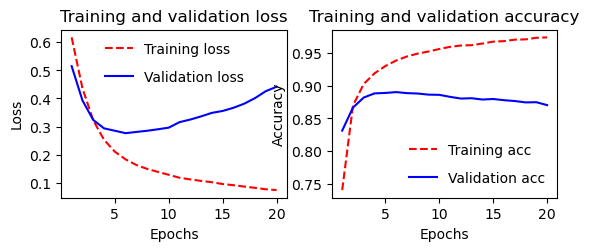

In [96]:
plot_loss_acc(M6b_history)

In [97]:
M6b_val_loss = M6b_history["val_loss"]
M6b_val_acc = M6b_history["val_accuracy"]
M6b_min_loss = format(min(M6b_val_loss),'.3f')
M6b_max_acc = format(max(M6b_val_acc),'.3f')

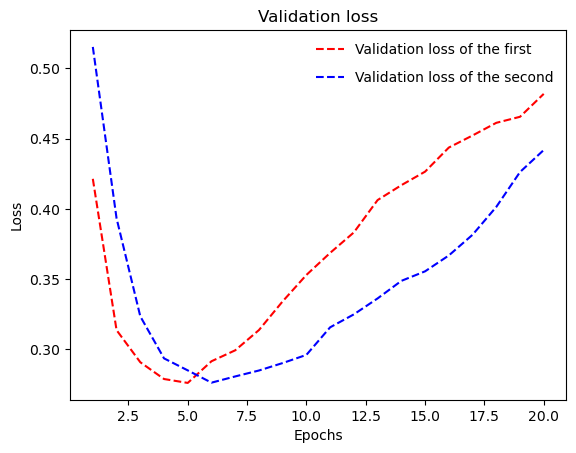

In [98]:
val_loss_compare(M1_val_loss,M6b_val_loss)

#### M6c: batch size = 1024

In [99]:
model = imdb_model(16,16,1,0.001,0.,0., 0 , None, None)
M6c_history = train(20,1024,0.4).history

Epoch 1/20


2022-11-13 22:29:55.081875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 42ms/step - loss: 0.6294 - accuracy: 0.6855 - val_loss: 0.5383 - val_accuracy: 0.8443
Epoch 2/20


2022-11-13 22:29:55.786586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 19ms/step - loss: 0.4753 - accuracy: 0.8564 - val_loss: 0.4342 - val_accuracy: 0.8569
Epoch 3/20
15/15 [==============================] - 0s 18ms/step - loss: 0.3763 - accuracy: 0.8948 - val_loss: 0.3767 - val_accuracy: 0.8778
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 0.3029 - accuracy: 0.9136 - val_loss: 0.3262 - val_accuracy: 0.8829
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 0.2547 - accuracy: 0.9228 - val_loss: 0.3042 - val_accuracy: 0.8915
Epoch 6/20
15/15 [==============================] - 0s 18ms/step - loss: 0.2202 - accuracy: 0.9354 - val_loss: 0.2881 - val_accuracy: 0.8924
Epoch 7/20
15/15 [==============================] - 0s 17ms/step - loss: 0.1973 - accuracy: 0.9392 - val_loss: 0.2811 - val_accuracy: 0.8949
Epoch 8/20
15/15 [==============================] - 0s 18ms/step - loss: 0.1782 - accuracy: 0.9471 - val_loss: 0.2853 - val_accuracy: 0.8923
Epoch 9/20
15/15 [======

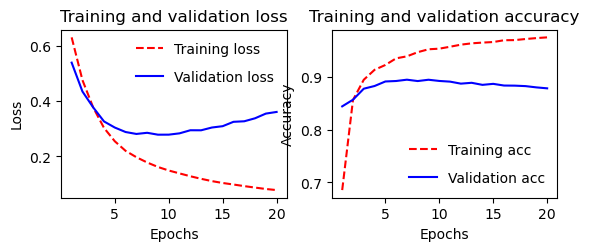

In [100]:
plot_loss_acc(M6c_history)

In [101]:
M6c_val_loss = M6c_history["val_loss"]
M6c_val_acc = M6c_history["val_accuracy"]
M6c_min_loss = format(min(M6c_val_loss),'.3f')
M6c_max_acc = format(max(M6c_val_acc),'.3f')

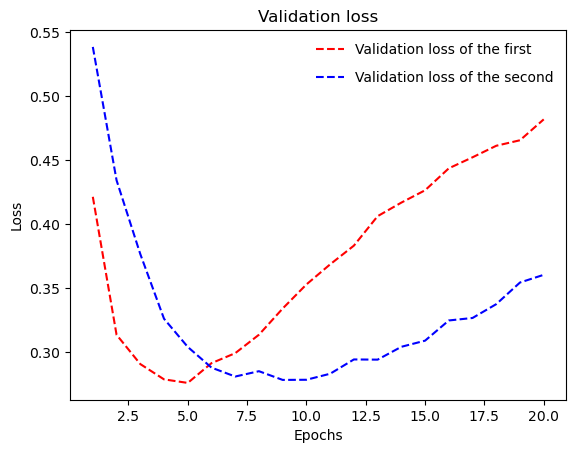

In [102]:
val_loss_compare(M1_val_loss,M6c_val_loss)

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2     |16       |0.005  |0.0  |n/a  |n/a |n/a   |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|<mark>M2b<mark>|2   |16  |0.0005 |0.0  |n/a |n/a |n/a|512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2     |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2     |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|<mark>M3b<mark>   |2   |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|<mark>M3c<mark>   |2     |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|<mark>{{M3c_min_loss}}<mark>|<mark>{{M3c_max_acc}}<mark>|
|M4a   |2       |16       |0.001 |0.0  |n/a  |n/a |0.5  |512|{{M4a_min_loss}}|{{M4a_max_acc}}|
|<mark>M4b<mark>   |2       |16       |0.001 |0.0  |n/a  |n/a |0.25|512 |<mark>{{M4b_min_loss}}<mark>|<mark>{{M4b_max_acc}}<mark>|
|M4c   |2       |16       |0.001 |0.0  |n/a  |n/a |0.37|512|{{M4c_min_loss}}|{{M4c_max_acc}}|
|M5a   |2       |16       |0.001 |0.0  |0.001  |n/a |n/a|512|{{M5a_min_loss}}|{{M5a_max_acc}}|
|M5b   |2       |16       |0.001 |0.0  |n/a  |0.001 |n/a|512|{{M5b_min_loss}}|{{M5b_max_acc}}|
|M5c   |2       |16       |0.001 |0.0  |0.001  |0.001 |n/a|512|{{M5c_min_loss}}|{{M5c_max_acc}}|
|M5d   |2       |16       |0.001 |0.0  |0.0001  |n/a |n/a|512|{{M5d_min_loss}}|{{M5d_max_acc}}|
|M5e   |2       |16       |0.001 |0.0  |n/a  |0.0001 |n/a|512|{{M5e_min_loss}}|{{M5e_max_acc}}|
|M5f   |2       |16       |0.001 |0.0  |0.0001  |0.0001 |n/a|512|{{M5f_min_loss}}|{{M5f_max_acc}}|
|M5g   |2       |16       |0.001 |0.0  |0.00001  |n/a |n/a|512|{{M5g_min_loss}}|{{M5g_max_acc}}|
|<mark>M5h<mark>  |2       |16     |0.001 |0.0  |n/a  |0.00001|n/a|512|<mark>{{M5h_min_loss}}<mark>|<mark>{{M5h_max_acc}}<mark>|
|M5i   |2       |16       |0.001 |0.0  |0.00001  |0.00001|n/a|512|{{M5i_min_loss}}|{{M5i_max_acc}}|
|M6a   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|256|{{M6a_min_loss}}|{{M6a_max_acc}}|    
|<mark>M6b<mark>   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|768|<mark>{{M6b_min_loss}}<mark>|<mark>{{M6b_max_acc}}<mark>|
|M6c   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|1024|{{M6c_min_loss}}|{{M6c_max_acc}}|

#### Observation and comments

It seems higher batch sizes leads to lower asymptotic test accuracy. 

When batch size = 768, the curve is smoother than 256 or 1024.

### Combining well performed hyperparameters(M7)

According to the chart, there're some well performed hyperparameter which might also lead to a good combination.

lr = 0.0005, mom = 0.5/0.7, dp = 0.25, l2(1e-5), batch_size = 512/768

choose two combinations to test:
- lr = 0.0005, mom = 0.7, dp = 0.25, l2(1e-5), batch_size = 768
- lr = 0.0005, mom = 0.5, dp = 0.25, l2(1e-5), batch_size = 512

In [103]:
model = imdb_model(16,16,1,0.0005,0.7,0.25, 1 , reg_type = regularizers.l2, reg_val = 1e-5)
M7a_history = train(20,768,0.4).history

Epoch 1/20


2022-11-13 22:30:01.809469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.6171

2022-11-13 22:30:02.643943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 41ms/step - loss: 0.6660 - accuracy: 0.6171 - val_loss: 0.6108 - val_accuracy: 0.7698
Epoch 2/20
20/20 [==============================] - 0s 20ms/step - loss: 0.5710 - accuracy: 0.7487 - val_loss: 0.5136 - val_accuracy: 0.8460
Epoch 3/20
20/20 [==============================] - 0s 20ms/step - loss: 0.4929 - accuracy: 0.8022 - val_loss: 0.4482 - val_accuracy: 0.8644
Epoch 4/20
20/20 [==============================] - 0s 22ms/step - loss: 0.4328 - accuracy: 0.8345 - val_loss: 0.3968 - val_accuracy: 0.8740
Epoch 5/20
20/20 [==============================] - 0s 20ms/step - loss: 0.3861 - accuracy: 0.8572 - val_loss: 0.3600 - val_accuracy: 0.8805
Epoch 6/20
20/20 [==============================] - 0s 20ms/step - loss: 0.3501 - accuracy: 0.8761 - val_loss: 0.3349 - val_accuracy: 0.8836
Epoch 7/20
20/20 [==============================] - 0s 20ms/step - loss: 0.3190 - accuracy: 0.8875 - val_loss: 0.3147 - val_accuracy: 0.8860
Epoch 8/20
20/20 [======

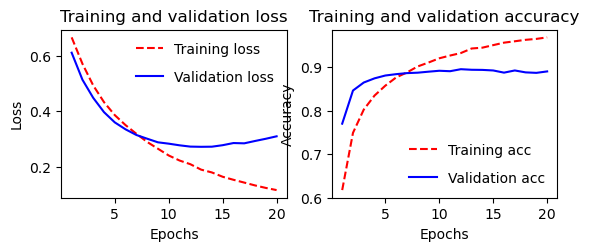

In [104]:
plot_loss_acc(M7a_history)

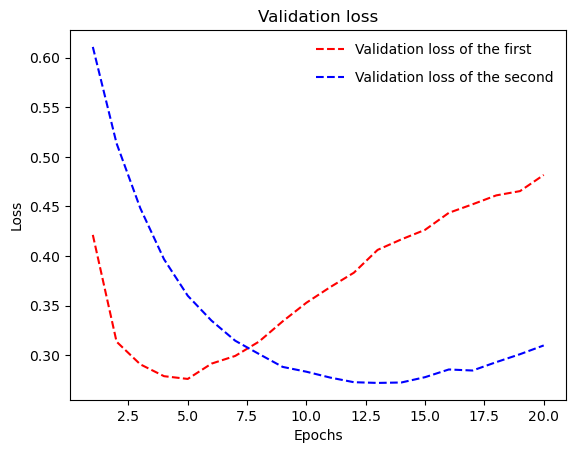

In [105]:
M7a_val_loss = M7a_history["val_loss"]
M7a_val_acc = M7a_history["val_accuracy"]
M7a_min_loss = format(min(M7a_val_loss),'.3f')
M7a_max_acc = format(max(M7a_val_acc),'.3f')
val_loss_compare(M1_val_loss,M7a_val_loss)

In [106]:
model = imdb_model(16,16,1,0.0005,0.5,0.25, 1 , reg_type = regularizers.l2, reg_val = 1e-5)
M7b_history = train(20,512,0.4).history

Epoch 1/20


2022-11-13 22:30:11.103316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.6535

2022-11-13 22:30:12.044737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 1s 31ms/step - loss: 0.6455 - accuracy: 0.6535 - val_loss: 0.5628 - val_accuracy: 0.8242
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.5185 - accuracy: 0.8028 - val_loss: 0.4526 - val_accuracy: 0.8647
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.4278 - accuracy: 0.8482 - val_loss: 0.3836 - val_accuracy: 0.8776
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3655 - accuracy: 0.8762 - val_loss: 0.3402 - val_accuracy: 0.8838
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3170 - accuracy: 0.8919 - val_loss: 0.3068 - val_accuracy: 0.8900
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2854 - accuracy: 0.9049 - val_loss: 0.2888 - val_accuracy: 0.8935
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2550 - accuracy: 0.9176 - val_loss: 0.2798 - val_accuracy: 0.8925
Epoch 8/20
30/30 [======

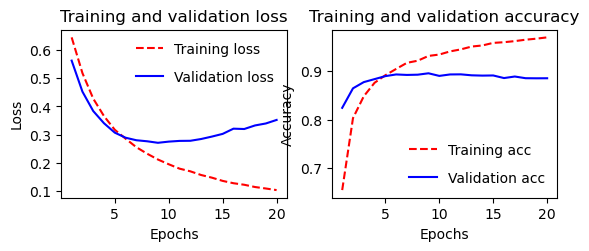

In [107]:
plot_loss_acc(M7b_history)

In [108]:
M7b_val_loss = M7b_history["val_loss"]
M7b_val_acc = M7b_history["val_accuracy"]
M7b_min_loss = format(min(M7b_val_loss),'.3f')
M7b_max_acc = format(max(M7b_val_acc),'.3f')

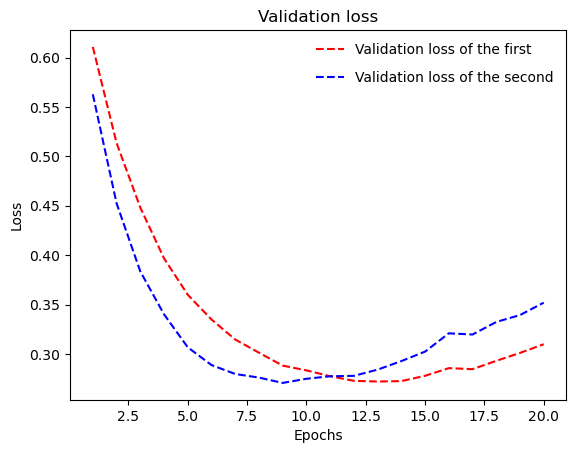

In [109]:
val_loss_compare(M7a_val_loss,M7b_val_loss)

**Performance on Validation Set comparison chart:**

|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2       |16       |0.005  |0.0  |n/a  |n/a |n/a |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|M2b   |2       |16       |0.0005 |0.0  |n/a  |n/a |n/a |512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2       |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2       |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|M3b   |2       |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|M3c   |2       |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|{{M3c_min_loss}}|{{M3c_max_acc}}|
|M4a   |2       |16       |0.001 |0.0  |n/a  |n/a |0.5  |512|{{M4a_min_loss}}|{{M4a_max_acc}}|
|M4b   |2       |16       |0.001 |0.0  |n/a  |n/a |0.25|512 |<mark>{{M4b_min_loss}}<mark>|<mark>{{M4b_max_acc}}<mark>|
|M4c   |2       |16       |0.001 |0.0  |n/a  |n/a |0.37|512|{{M4c_min_loss}}|{{M4c_max_acc}}|
|M5a   |2       |16       |0.001 |0.0  |0.001  |n/a |n/a|512|{{M5a_min_loss}}|{{M5a_max_acc}}|
|M5b   |2       |16       |0.001 |0.0  |n/a  |0.001 |n/a|512|{{M5b_min_loss}}|{{M5b_max_acc}}|
|M5c   |2       |16       |0.001 |0.0  |0.001  |0.001 |n/a|512|{{M5c_min_loss}}|{{M5c_max_acc}}|
|M5d   |2       |16       |0.001 |0.0  |0.0001  |n/a |n/a|512|{{M5d_min_loss}}|{{M5d_max_acc}}|
|M5e   |2       |16       |0.001 |0.0  |n/a  |0.0001 |n/a|512|{{M5e_min_loss}}|{{M5e_max_acc}}|
|M5f   |2       |16       |0.001 |0.0  |0.0001  |0.0001 |n/a|512|{{M5f_min_loss}}|{{M5f_max_acc}}|
|M5g   |2       |16       |0.001 |0.0  |0.00001  |n/a |n/a|512|{{M5g_min_loss}}|{{M5g_max_acc}}|
|M5h   |2       |16     |0.001 |0.0  |n/a  |0.00001|n/a|512|<mark>{{M5h_min_loss}}<mark>|<mark>{{M5h_max_acc}}<mark>|
|M5i   |2       |16       |0.001 |0.0  |0.00001  |0.00001|n/a|512|{{M5i_min_loss}}|{{M5i_max_acc}}|
|M6a   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|256|{{M6a_min_loss}}|{{M6a_max_acc}}|    
|M6b   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|768|{{M6b_min_loss}}|{{M6b_max_acc}}|
|M6c   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|1024|{{M6c_min_loss}}|{{M6c_max_acc}}|
|<mark>M7a<mark>    |2       |16       |0.0005 |0.7  |n/a  |n/a |0.25 |768 |<mark>{{M7a_min_loss}}<mark>|<mark>{{M7a_max_acc}}<mark>|
|M7b    |2       |16       |0.0005 |0.5  |n/a  |n/a |0.25 |512 |{{M7b_min_loss}}|{{M7b_max_acc}}|

#### Observation and comments

M7a has better and smoother curve than M7b. And the figure is good since it applied l2 regularization.

### Grid search(M8)

Since it's very expensive to do the grid search, and the one with l1/l2 regularization costs even more. In order to find something quicker, splitting the grid search in two different session, the first one doesnt use l1/l2 regularization, and the second one use them. (However I won't run the second one again since it costs me two days to run it but still couldn't finish the task)

In [110]:
#def imdb_model(layer_1_units, layer_2_units, layer_3_units, 
#lr, momentum, dp, use_regularizer, reg1_type, reg2_type, reg_val):
   
# use_regularizer = 0
# lrs = [0.001, 0.005, 0.0005, lr_schedule]
# moms = [0., 0.9, 0.5, 0.7]
# dps = [0., 0.5, 0.25, 0.37]
# sizes = [256, 512, 768, 1024]

# all_his_noreg={}

# for lr in lrs:
  #  for momentum in moms:
        # for dp in dps:
            # for size in sizes:
                
              #   model = imdb_model(16, 16, 1, lr, momentum, dp, 0, None, None)
              #   M8a_history = train(20,size,0.4).history
              #   M8a_history_val_loss = M8a_history["val_loss"]
              #   M8a_history_val_acc = M8a_history["val_accuracy"]
              #   M8a_history_min_loss = format(min(M8a_history_val_loss),'.3f')
              #   M8a_history_max_acc = format(max(M8a_history_val_acc),'.3f')
              #   print("*********" , M8a_history_min_loss, M8a_history_max_acc , "*********" )
              #   print("*********" , "lr = ", lr, "momentum = ", momentum, "dp = ", dp , "size = ", size, "*********" )
            


The best hyperparameter combination that searched by the grid is

********* lr =  0.0005 momentum =  0.0 dp =  0.0 size =  1024 *********

In [111]:
model = imdb_model(16,16,1,0.0005,0.,0., 0, None, None)
M8_history = train(20,1024,0.4).history

Epoch 1/20


2022-11-13 22:30:23.455666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 40ms/step - loss: 0.6669 - accuracy: 0.6655 - val_loss: 0.6164 - val_accuracy: 0.7948
Epoch 2/20
 1/15 [=>............................] - ETA: 0s - loss: 0.6134 - accuracy: 0.8066

2022-11-13 22:30:24.097441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 18ms/step - loss: 0.5658 - accuracy: 0.8345 - val_loss: 0.5201 - val_accuracy: 0.8444
Epoch 3/20
15/15 [==============================] - 0s 17ms/step - loss: 0.4694 - accuracy: 0.8732 - val_loss: 0.4490 - val_accuracy: 0.8558
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 0.3961 - accuracy: 0.8899 - val_loss: 0.3926 - val_accuracy: 0.8718
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 0.3389 - accuracy: 0.9021 - val_loss: 0.3544 - val_accuracy: 0.8777
Epoch 6/20
15/15 [==============================] - 0s 17ms/step - loss: 0.2950 - accuracy: 0.9113 - val_loss: 0.3248 - val_accuracy: 0.8832
Epoch 7/20
15/15 [==============================] - 0s 17ms/step - loss: 0.2604 - accuracy: 0.9201 - val_loss: 0.3054 - val_accuracy: 0.8878
Epoch 8/20
15/15 [==============================] - 0s 17ms/step - loss: 0.2335 - accuracy: 0.9269 - val_loss: 0.2930 - val_accuracy: 0.8883
Epoch 9/20
15/15 [======

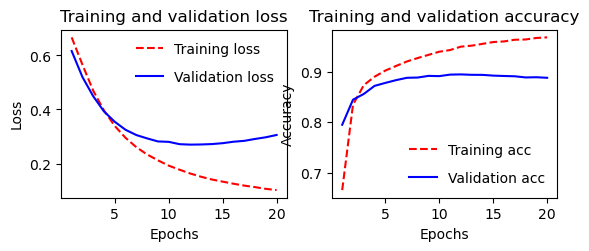

In [112]:
plot_loss_acc(M8_history)

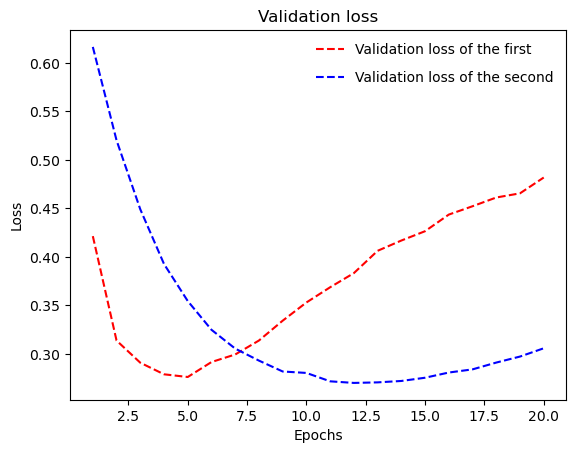

In [113]:
M8_val_loss = M8_history["val_loss"]
M8_val_acc = M8_history["val_accuracy"]
M8_min_loss = format(min(M8_val_loss),'.3f')
M8_max_acc = format(max(M8_val_acc),'.3f')
val_loss_compare(M1_val_loss,M8_val_loss)

**Performance on Validation Set comparison chart:**


|Model:| Layers:| Units: |lr:    |mom: |l1: | l2: |dropout:|bat.size:| Min.V.Loss:| Max.V.Acc:  |
|:-----|:-------|:-------|:------|:----|:---|:----|:-------|:-------|:-------------|:------------- |
|M1    |2     |16       |0.001  |0.0  |n/a  |n/a |n/a   |512|{{M1_min_loss}}|{{M1_max_acc}}|
|M2a   |2       |16       |0.005  |0.0  |n/a  |n/a |n/a |512|{{M2a_min_loss}}|{{M2a_max_acc}}|
|M2b   |2       |16       |0.0005 |0.0  |n/a  |n/a |n/a |512|<mark>{{M2b_min_loss}}<mark>|<mark>{{M2b_max_acc}}<mark>|
|M2c   |2       |16       |schedual |0.0  |n/a  |n/a |n/a |512|{{M2c_min_loss}}|{{M2c_max_acc}}|
|M3a   |2       |16       |0.001 |0.9  |n/a  |n/a |n/a  |512|{{M3a_min_loss}}|{{M3a_max_acc}}|
|M3b   |2       |16       |0.001 |0.5  |n/a  |n/a |n/a  |512|<mark>{{M3b_min_loss}}<mark>|<mark>{{M3b_max_acc}}<mark>|
|M3c   |2       |16       |0.001 |0.7  |n/a  |n/a |n/a  |512|{{M3c_min_loss}}|{{M3c_max_acc}}|
|M4a   |2       |16       |0.001 |0.0  |n/a  |n/a |0.5  |512|{{M4a_min_loss}}|{{M4a_max_acc}}|
|M4b   |2       |16       |0.001 |0.0  |n/a  |n/a |0.25|512 |<mark>{{M4b_min_loss}}<mark>|<mark>{{M4b_max_acc}}<mark>|
|M4c   |2       |16       |0.001 |0.0  |n/a  |n/a |0.37|512|{{M4c_min_loss}}|{{M4c_max_acc}}|
|M5a   |2       |16       |0.001 |0.0  |0.001  |n/a |n/a|512|{{M5a_min_loss}}|{{M5a_max_acc}}|
|M5b   |2       |16       |0.001 |0.0  |n/a  |0.001 |n/a|512|{{M5b_min_loss}}|{{M5b_max_acc}}|
|M5c   |2       |16       |0.001 |0.0  |0.001  |0.001 |n/a|512|{{M5c_min_loss}}|{{M5c_max_acc}}|
|M5d   |2       |16       |0.001 |0.0  |0.0001  |n/a |n/a|512|{{M5d_min_loss}}|{{M5d_max_acc}}|
|M5e   |2       |16       |0.001 |0.0  |n/a  |0.0001 |n/a|512|{{M5e_min_loss}}|{{M5e_max_acc}}|
|M5f   |2       |16       |0.001 |0.0  |0.0001  |0.0001 |n/a|512|{{M5f_min_loss}}|{{M5f_max_acc}}|
|M5g   |2       |16       |0.001 |0.0  |0.00001  |n/a |n/a|512|{{M5g_min_loss}}|{{M5g_max_acc}}|
|M5h   |2       |16     |0.001 |0.0  |n/a  |0.00001|n/a|512|<mark>{{M5h_min_loss}}<mark>|<mark>{{M5h_max_acc}}<mark>|
|M5i   |2       |16       |0.001 |0.0  |0.00001  |0.00001|n/a|512|{{M5i_min_loss}}|{{M5i_max_acc}}|
|M6a   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|256|{{M6a_min_loss}}|{{M6a_max_acc}}|    
|M6b   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|768|{{M6b_min_loss}}|{{M6b_max_acc}}|
|M6c   |2       |16       |0.001 |0.0  |n/a  |n/a |n/a|1024|{{M6c_min_loss}}|{{M6c_max_acc}}|
|<mark>M7a<mark>    |2       |16       |0.0005 |0.7  |n/a  |n/a |0.25 |768 |<mark>{{M7a_min_loss}}<mark>|<mark>{{M7a_max_acc}}<mark>|
|M7b    |2       |16       |0.0005 |0.5  |n/a  |n/a |0.25 |512 |{{M7b_min_loss}}|{{M7b_max_acc}}|
|<mark>M8<mark>    |2       |16       |0.0005 |0.0  |n/a  |n/a |0.0 |1024 |<mark>{{M8_min_loss}}<mark>|<mark>{{M8_max_acc}}<mark>|
    


In [114]:
#def imdb_model(layer_1_units, layer_2_units, layer_3_units, 
#lr, momentum, dp, use_regularizer, reg_type,  reg_val):


# THIS IS EXPENSIVE（2022-11-11 23：58:13 ～2022-11-13 14:29:33 didnt finish)


# lrs = [0.001, 0.005, 0.0005, lr_schedule]
# moms = [0., 0.9, 0.5, 0.7]
# dps = [0., 0.5, 0.25, 0.37]
# sizes = [256, 512, 768, 1024]
# use_regularizer = 1
# reg_types = [regularizers.l1, regularizers.l2, regularizers.l1_l2]
# reg_vals = [1e-3, 1e-4, 1e-5]


# for lr in lrs:
    # for momentum in moms:
        # for dp in dps:
            # for size in sizes:
               #  for reg_type in reg_types:
                   #  for reg_val in reg_vals:
                      #   model = imdb_model(16, 16, 1, lr, momentum, dp, use_regularizer, reg_type, reg_val)
                      #   M8b_history = train(20,size,0.4).history
                      #   M8b_history_val_loss = M8b_history["val_loss"]
                      #   M8b_history_val_acc = M8b_history["val_accuracy"]
                      #   M8b_history_min_loss = format(min(M8b_history_val_loss),'.3f')
                      #   M8b_history_max_acc = format(max(M8b_history_val_acc),'.3f')
                      #   print("*********" , M8b_history_min_loss, M8b_history_max_acc , "*********" )
                      #   print("*********" , "lr = ", lr, "momentum = ", momentum, "dp = ", dp , "reg_type = ", reg_type, "reg_val = ", reg_val, "size = ", size, "*********" )



#### Observation and comments

When lr = 0.0005, batch_size = 1024, the validation loss of model(M8) reached its minimum at the 11th epoch, and shows a suppressed curve afterwards which indicates that the overfitting has been well handled in the model.

## Retraining 

Choosing M8 model's parameter to retrain the model on the whole training set.

In [115]:
tf.keras.backend.clear_session() 

model = keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16 ,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train,
        y_train,
        epochs=20,
        batch_size=1024)


Epoch 1/20


2022-11-13 22:30:29.997014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 14ms/step - loss: 0.5679 - accuracy: 0.7768
Epoch 2/20
25/25 [==============================] - 0s 10ms/step - loss: 0.4063 - accuracy: 0.8792
Epoch 3/20
25/25 [==============================] - 0s 11ms/step - loss: 0.3250 - accuracy: 0.8993
Epoch 4/20
25/25 [==============================] - 0s 10ms/step - loss: 0.2721 - accuracy: 0.9130
Epoch 5/20
25/25 [==============================] - 0s 10ms/step - loss: 0.2349 - accuracy: 0.9230
Epoch 6/20
25/25 [==============================] - 0s 9ms/step - loss: 0.2086 - accuracy: 0.9300
Epoch 7/20
25/25 [==============================] - 0s 9ms/step - loss: 0.1889 - accuracy: 0.9381
Epoch 8/20
25/25 [==============================] - 0s 9ms/step - loss: 0.1726 - accuracy: 0.9427
Epoch 9/20
25/25 [==============================] - 0s 10ms/step - loss: 0.1586 - accuracy: 0.9488
Epoch 10/20
25/25 [==============================] - 0s 9ms/step - loss: 0.1461 - accuracy: 0.9533
Epoch 11/20
25/25 [=====

# Results
---

Now we have the model trained. Let's use it on the testing dataset.

This part's code is referenced from the course material: 04.1.classifying-movie-reviews-imdb

In [116]:
results = model.evaluate(x_test, y_test, verbose=0)

print(f"loss: {results[0]}, accuracy: {results[1]}") 
# The result is better than before.

2022-11-13 22:30:35.611489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


loss: 0.40064993500709534, accuracy: 0.8664800524711609


In [117]:
>>> model.predict(x_test[:10],verbose=0)

2022-11-13 22:30:38.175667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[7.2171576e-02],
       [9.9996889e-01],
       [4.3631682e-01],
       [8.9274114e-01],
       [9.7842479e-01],
       [9.0911239e-01],
       [9.9995852e-01],
       [4.0294038e-04],
       [9.7299057e-01],
       [9.9961239e-01]], dtype=float32)

In [118]:
def print_predictions(preds, init=0):
    labels = ["negative", "positive"]
    for i, pred in enumerate(preds.ravel()): # ravel() makes the array flat (1D)
        print(f"Review n° {init+i} is {labels[int(pred > .5)]} | score: {pred:.5f}")

In [119]:
print_predictions(model.predict(x_test[:10], verbose=0))

Review n° 0 is negative | score: 0.07217
Review n° 1 is positive | score: 0.99997
Review n° 2 is negative | score: 0.43632
Review n° 3 is positive | score: 0.89274
Review n° 4 is positive | score: 0.97842
Review n° 5 is positive | score: 0.90911
Review n° 6 is positive | score: 0.99996
Review n° 7 is negative | score: 0.00040
Review n° 8 is positive | score: 0.97299
Review n° 9 is positive | score: 0.99961


In [120]:
test_labels[:10] 

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1])

In [121]:
print('review', '\t', 'prediction → rounded', '\t', 'label', '\t', 'correct?')
print()
for i in range(20):
    y_pred = model.predict(x_test[i:i+1], verbose=0)[0][0]
    print(i, '\t', y_pred,'\t', round(y_pred), '\t', test_labels[i], '\t', int(y_pred > .5) == test_labels[i])

review 	 prediction → rounded 	 label 	 correct?

0 	 0.07217158 	 0 	 0 	 True
1 	 0.9999689 	 1 	 1 	 True
2 	 0.4363165 	 0 	 1 	 False
3 	 0.89274114 	 1 	 0 	 False
4 	 0.9784248 	 1 	 1 	 True
5 	 0.9091124 	 1 	 1 	 True
6 	 0.9999585 	 1 	 1 	 True
7 	 0.00040294012 	 0 	 0 	 True
8 	 0.9729906 	 1 	 0 	 False
9 	 0.9996124 	 1 	 1 	 True
10 	 0.9681766 	 1 	 1 	 True
11 	 0.0013961036 	 0 	 0 	 True
12 	 2.8448872e-07 	 0 	 0 	 True
13 	 0.03558223 	 0 	 0 	 True
14 	 0.99911267 	 1 	 1 	 True
15 	 1.2806065e-07 	 0 	 0 	 True
16 	 0.92478335 	 1 	 1 	 True
17 	 0.91216207 	 1 	 0 	 False
18 	 0.00010533957 	 0 	 0 	 True
19 	 0.0045867963 	 0 	 0 	 True


In [122]:
def review_finder(prediction, label):
    for i in range(len(x_test)):                                      
        y_pred = round(model.predict(x_test[i:i+1], verbose=0)[0, 0])  
        if y_pred == prediction and test_labels[i] == label:           
            yield i                                                    

In [123]:
def print_review(n):
    word_index = imdb.get_word_index()                                                                  
    reverse_word_index = {value:key for key,value in word_index.items()} 
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[n]])

    y_pred = model.predict(x_test[n:n+1], verbose=0)[0,0]                                                 
    print(f"review: {n} | predicted: {y_pred:.6f} | rounded: {round(y_pred)} | label: {test_labels[n]}")  
    print()
    print(decoded_review, '\n')   

In [124]:
neg_neg = review_finder(prediction=0, label=0) 
print_review(next(neg_neg)) 

review: 0 | predicted: 0.072172 | rounded: 0 | label: 0

? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss 



In [125]:
pos_pos = review_finder(prediction=1, label=1) 
print_review(next(pos_pos))

review: 1 | predicted: 0.999969 | rounded: 1 | label: 1

? this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances ? the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere ? with sexual tension and psychological ? it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the ? moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual ? and de

In [126]:
neg_pos = review_finder(prediction=0, label=1)
print_review(next(neg_pos))

review: 2 | predicted: 0.436316 | rounded: 0 | label: 1

? many animation buffs consider ? ? the great forgotten genius of one special branch of the art puppet animation which he invented almost single ? and as it happened almost accidentally as a young man ? was more interested in ? than the cinema but his ? attempt to film two ? ? fighting led to an unexpected breakthrough in film making when he realized he could ? movement by ? beetle ? and ? them one frame at a time this discovery led to the production of amazingly elaborate classic short the ? revenge which he made in russia in ? at a time when motion picture animation of all sorts was in its ? br br the political ? of the russian revolution caused ? to move to paris where one of his first productions ? was a dark political satire ? known as ? or the ? who wanted a king a strain of black comedy can be found in almost all of films but here it is very dark indeed aimed more at grown ups who can appreciate the satirical aspects than 

In [127]:
pos_neg = review_finder(prediction=1, label=0) 
print_review(next(pos_neg))

review: 3 | predicted: 0.892741 | rounded: 1 | label: 0

? i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are ? involved with the actions on the screen so then why the hell can't we have night vision 



# Conclusions
---

This machine learning task is supervised learning. The process focuses on preprocessing the data, feeding it into a model for training and validation, finding the combination of parameters that makes the least loss, and applying the model to the test set for prediction.

First, the effect of each parameter on the model was investigated using the control variables method, i.e., only the value of one parameter was changed at a time, thus excluding the effect of other variables. Since too many iterations may cause the model to overfit on the validation set, the parameter values were limited to about three as much as possible, since three values also allow a relatively intuitive view of the parameter effects.

Then the values that perform better in each parameter adjustment are selected for combination, because these values are generated without the influence of other variables, and when they are used together, they may also repel each other and thus produce worse results than when they are used alone, so it is worth trying them out.

The set of parameter values for optimal performance was found by grid search, and only the search without L1/L2 regularization parameters was used because of the high cost of grid search. A set of parameter values was found that performed better than the previous combination.

Buid the model from scratch with this set of parameters, trained on the entire training set, and predicted, yielding better results.

# References


1. Chollet, Francois. Deep Learning with Python. Shelter Island, NY: Manning Publications, 2021.
2. Jérémie, Wenger. Artificial Intelligence course materials: 04.1.classifying-movie-reviews-imdb, 06.universal-workflow, 2022.